In [1]:
import sys
import os
import datetime
import numpy as np
import scipy as sp
import scipy.fftpack
import scipy.io
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
import matplotlib.ft2font as ft
import matplotlib.font_manager as font_manager
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.labelsize'] = 10

plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
mpl.rcParams['xtick.labelsize']  = 8
mpl.rcParams['ytick.labelsize']  = 8
plt.rcParams['figure.dpi'] = 350
import nitime.algorithms as tsa
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import warnings
warnings.filterwarnings('ignore')

font = {'family' : 'arial',
        'weight' : 'normal',
        'size'   : 16}

plt.rc('font', **font)
plt.rc({'axes.labelsize', 'medium'})
wellpath = r'C:\Users\Martina\Google Drive\tide_induced_gw_level\spreadsheets\wells_fft'
#wpath = os.path.join( wellpath, 'mb2019.csv') 
wpath = os.path.join( wellpath, 'mb2020.csv') 
df = pd.read_csv(wpath)

In [2]:
df['tide'] = df['tide'].interpolate(method='linear')
nan_true = df['tide'].isnull().values.any() #check if there are nan values
print('Are there NaN values? ',nan_true)
quantity_nan = df['tide'].isnull().sum() # how many nan values
print('There are: ', quantity_nan, 'NaN')

#Find linear trend
short = df.iloc[0:1242,:]
tide = df['tide']*0.3048
coeff_obs = np.polyfit(df['index'],tide, 1)
print('The linear trend coefficients for observed tide are', coeff_obs[0], 'mm hr-1 and ', coeff_obs[1], 'mm')
print('The linear trend coefficients for observed tide are', coeff_obs[0]*24*365.25, 'mm yr-1 and ', coeff_obs[1], 'mm')
trend_obs = np.polyval(coeff_obs, df['index'])
SL_detrend_obs = np.subtract(tide, trend_obs)

# We now compute the Fourier transform and the spectral density of the signal. 
# The first step is to compute the FFT of the signal using the fft() function:
tide_fft_obs = np.fft.fft(SL_detrend_obs)

# Once the FFT has been obtained, square  
# its absolute value in order to get the power spectral density (PSD):
tide_psd_obs = np.abs(tide_fft_obs) ** 2

# The next step is to get the frequencies corresponding to the values of the PSD. 
# The fftfreq() utility function does just that. 
# It takes the length of the PSD vector as input as well as the frequency unit. 
# Here, we choose an annual unit: a frequency of 1 corresponds to 1 year (365.25 days),(1 day = 24 hours). 
# We divide 1/(365.25*24) because the original unit is in hours:
fftfreqs_obs = np.fft.fftfreq(len(tide))

# The fftfreq() function returns positive and negative frequencies. 
# We are only interested in positive frequencies here, as we have a real signal:
i = fftfreqs_obs > 0
print('Fourier Transform')
print(tide_fft_obs[706])
f2_obs = np.log10(tide_psd_obs[i])
print('power spectral density')
print(tide_psd_obs[706])
print('log10 power spectral density')
print(f2_obs[706])
print('frequencies (hour^-1)')
f1_obs=fftfreqs_obs[i]
print(f1_obs[705:710])
print('fft amplitude (m)')
amp_obs = 2.*np.abs(tide_fft_obs[i])/len(tide_fft_obs)
print(amp_obs[706]) 
#print(2.*np.abs(tide_fft[i])/len(tide_fft))
print('periods (hours)')
print(1/f1_obs[706])
print(len(tide_fft_obs[i]))
print(len(fftfreqs_obs[i]))

tide_fft_selected_obs = tide_fft_obs.copy()
tide_fft_selected_obs[np.abs(fftfreqs_obs) >0.0806] = 0
tide_fft_selected_obs[np.abs(fftfreqs_obs) <0.0804] = 0
t_slow_obs = np.real(sp.fftpack.ifft(tide_fft_selected_obs))
np.savetxt('test.csv',t_slow_obs)

Are there NaN values?  False
There are:  0 NaN
The linear trend coefficients for observed tide are -2.5288392152819826e-05 mm hr-1 and  0.012754585844869923 mm
The linear trend coefficients for observed tide are -0.22167804561161858 mm yr-1 and  0.012754585844869923 mm
Fourier Transform
(-58.99659407731349+23.09962308267343j)
power spectral density
4014.1906992848803
log10 power spectral density
6.232867236114477
frequencies (hour^-1)
[0.08039171 0.08050558 0.08061945 0.08073332 0.08084719]
fft amplitude (m)
0.29776262261331643
periods (hours)
12.421499292786422
4390
4390


Text(0.079, 1780000, 'M2')

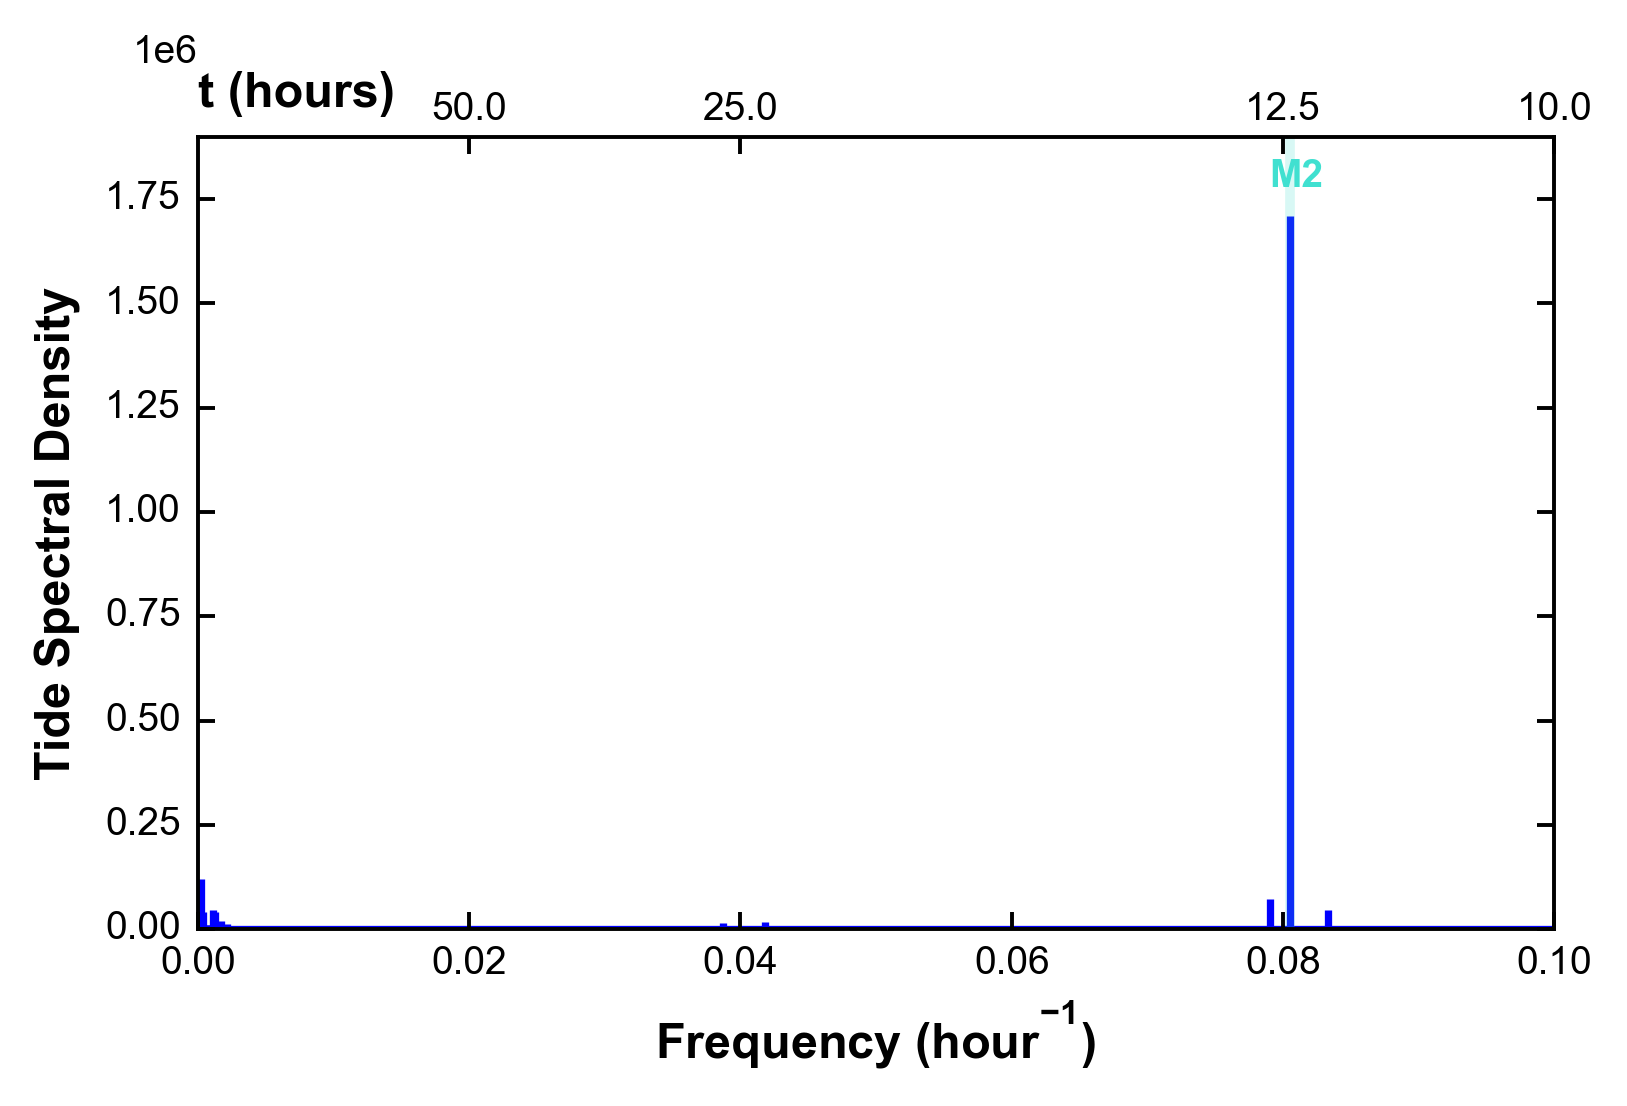

In [3]:
vspan_start1 = fftfreqs_obs[fftfreqs_obs==0.08]
vspan_end1 = 1.92
vspan_start2 = 0.099
vspan_end2 = 0.101
xlim_start = 0.000
xlim_end = 0.10

n2 = 0.076
m2 = 0.079
s2 =0.082
k1 = 0.0405
o1 = 0.035
tt1 = 1780000
tt = 1650000

i = fftfreqs_obs > 0
new_tick_locations = np.array([0.02, 0.04,0.08,0.1])
def tick_function(X):
    V = 1/X
    return ["%.1f" % z for z in V]

plt.figure(figsize=(5,3))

ax = host_subplot(111, axes_class=AA.Axes)
ax.set_xlim([0,xlim_end])
ax.set_ylim([0,1900000])
ax.set_xlabel('Frequency ($\mathregular{hour^{-1}}$)')
ax.set_ylabel('Tide Spectral Density')
ax.set_title('t (hours)', loc='left')
ax2 = ax.twin() # ax2 is responsible for "top" axis and "right" axis
ax2.axis["top"].major_ticklabels.set_visible(True)
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tick_function(new_tick_locations))
plt.stem(fftfreqs_obs[i], tide_psd_obs[i], 'b', \
         markerfmt=" ", basefmt="-b")
#ax.axvline(x = fftfreqs_obs[366],linewidth=2,linestyle= '-', color= 'orange', alpha=0.2)
#ax.axvline(x = fftfreqs_obs[693],linewidth=2,linestyle= '-', color= 'green', alpha=0.2)
ax.axvline(x = fftfreqs_obs[707],linewidth=2,linestyle= '-', color= 'turquoise', alpha=0.2)
#ax.axvline(x = fftfreqs_obs[731],linewidth=2,linestyle= '-', color= 'purple', alpha=0.2)
#ax.axvline(x = fftfreqs_obs[340],linewidth=2,linestyle= '-', color= 'red', alpha=0.2)
#ax.text(n2, tt, 'N2',color='green', size=8, weight='heavy')
ax.text(m2, tt1, 'M2',color='turquoise', size=8, weight='heavy')
#ax.text(s2,tt, 'S2',color='purple', size=8, weight='heavy')
#ax.text(k1, tt, 'K1',color='orange', size=8, weight='heavy')
#ax.text(o1, tt, 'O1',color='red', size=8, weight='heavy')

Are there NaN values?  False
There are:  0 NaN
The linear trend coefficients for observed tide are -2.3534475083755446e-05 mm hr-1 and  0.10636216338588021 mm
The linear trend coefficients for observed tide are -0.20630320858420023 mm yr-1 and  0.10636216338588021 mm
Fourier Transform
(-27.855127672608674+42.922196056151094j)
power spectral density
2618.2230519400023
log10 power spectral density
5.855341536420551
frequencies (hour^-1)
[0.08016397 0.08027784 0.08039171 0.08050558 0.08061945 0.08073332
 0.08084719]
fft amplitude (m)
0.19280013386482303
periods (hours)
12.421499292786422
4390
4390


Text(0.035, 720000, 'O1')

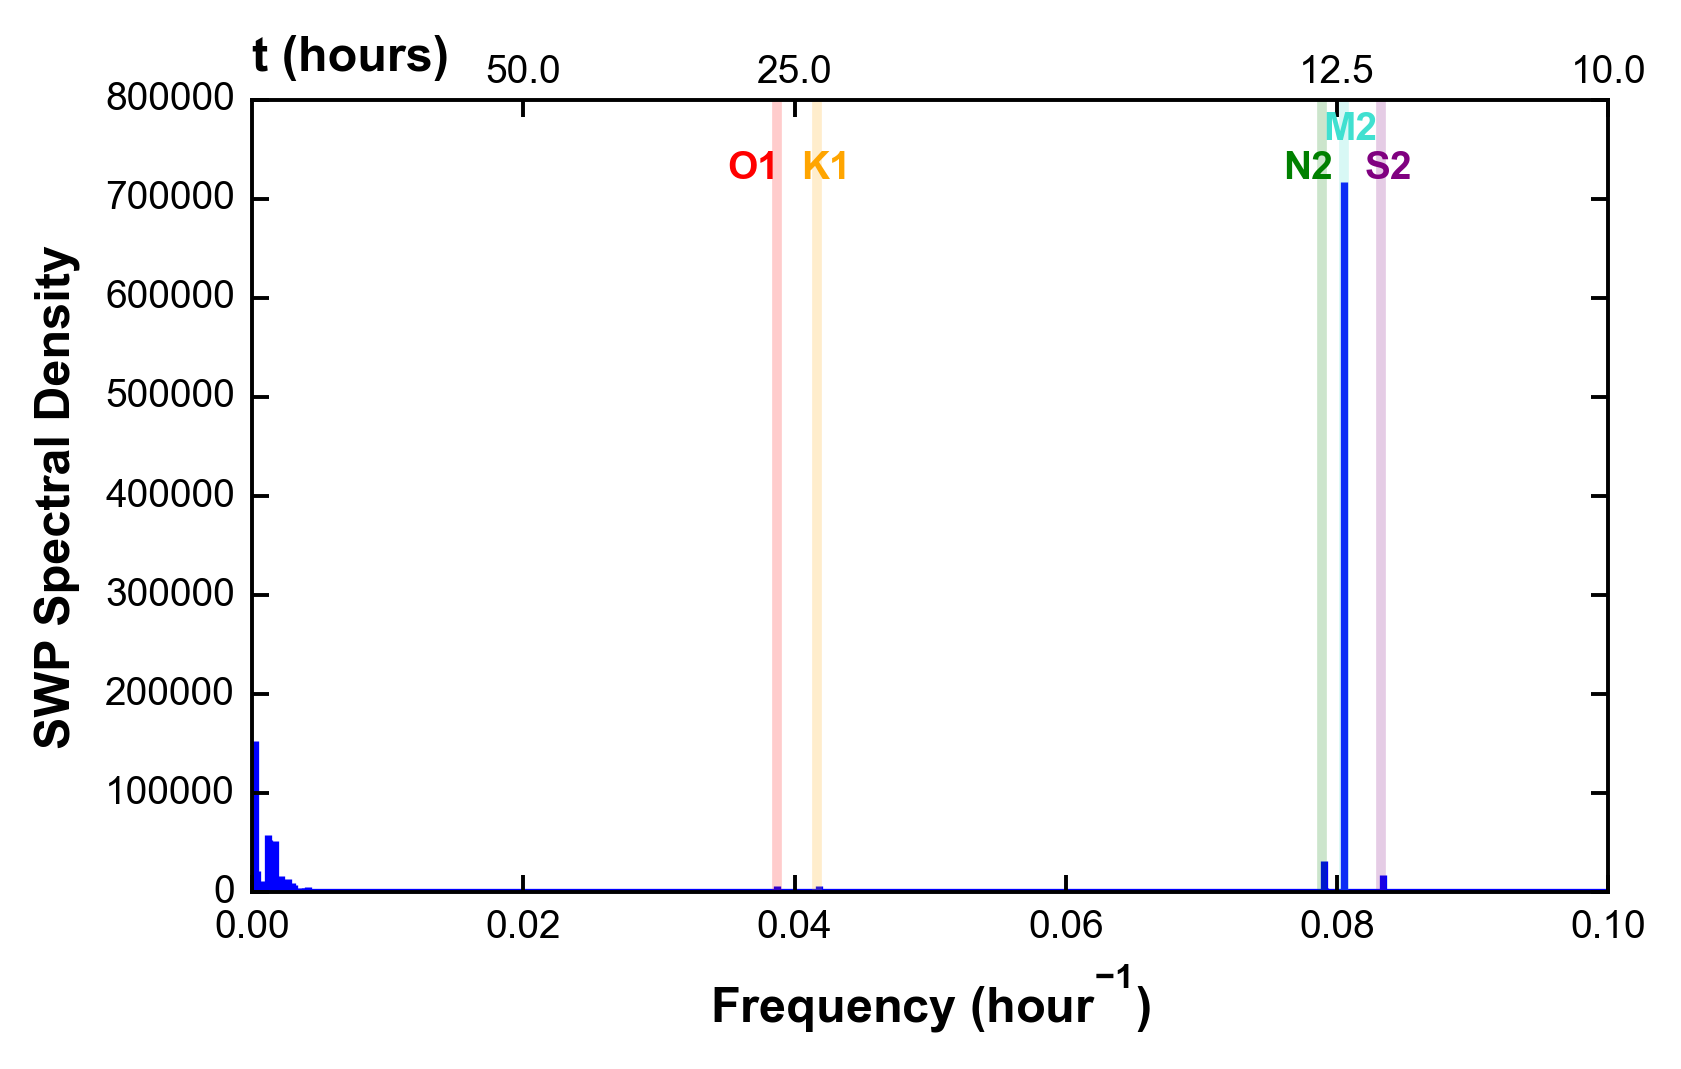

In [4]:
df['SWP'] = df['SWP'].interpolate(method='linear')
nan_true = df['SWP'].isnull().values.any() #check if there are nan values
print('Are there NaN values? ',nan_true)
quantity_nan = df['SWP'].isnull().sum() # how many nan values
print('There are: ', quantity_nan, 'NaN')

short = df.iloc[0:1242,:]
tide = df['SWP']*0.3048
coeff_obs = np.polyfit(df['index'],tide, 1)
print('The linear trend coefficients for observed tide are', coeff_obs[0], 'mm hr-1 and ', coeff_obs[1], 'mm')
print('The linear trend coefficients for observed tide are', coeff_obs[0]*24*365.25, 'mm yr-1 and ', coeff_obs[1], 'mm')
trend_obs = np.polyval(coeff_obs, df['index'])
SL_detrend_obs = np.subtract(tide, trend_obs)

tide_fft_obs = np.fft.fft(SL_detrend_obs)

# Once the FFT has been obtained, square  
# its absolute value in order to get the power spectral density (PSD):
tide_psd_obs = np.abs(tide_fft_obs) ** 2

# The next step is to get the frequencies corresponding to the values of the PSD. 
# The fftfreq() utility function does just that. 
# It takes the length of the PSD vector as input as well as the frequency unit. 
# Here, we choose an annual unit: a frequency of 1 corresponds to 1 year (365.25 days),(1 day = 24 hours). 
# We divide 1/(365.25*24) because the original unit is in hours:
fftfreqs_obs = np.fft.fftfreq(len(tide))

# The fftfreq() function returns positive and negative frequencies. 
# We are only interested in positive frequencies here, as we have a real signal:
i = fftfreqs_obs > 0
print('Fourier Transform')
print(tide_fft_obs[706])
f2_obs = np.log10(tide_psd_obs[i])
print('power spectral density')
print(tide_psd_obs[706])
print('log10 power spectral density')
print(f2_obs[706])
print('frequencies (hour^-1)')
f1_obs=fftfreqs_obs[i]
print(f1_obs[703:710])
print('fft amplitude (m)')
amp_obs = 2.*np.abs(tide_fft_obs[i])/len(tide_fft_obs)
print(amp_obs[706]) 
#print(2.*np.abs(tide_fft[i])/len(tide_fft))
print('periods (hours)')
print(1/f1_obs[706])
print(len(tide_fft_obs[i]))
print(len(fftfreqs_obs[i]))

tide_fft_selected_obs = tide_fft_obs.copy()
tide_fft_selected_obs[np.abs(fftfreqs_obs) >0.0806] = 0
tide_fft_selected_obs[np.abs(fftfreqs_obs) <0.0804] = 0
t_slow_obs = np.real(sp.fftpack.ifft(tide_fft_selected_obs))
np.savetxt('test.csv',t_slow_obs)

vspan_start1 = fftfreqs_obs[fftfreqs_obs==0.08]
vspan_end1 = 1.92
vspan_start2 = 0.099
vspan_end2 = 0.101
xlim_start = 0.000
xlim_end = 0.10

n2 = 0.076
m2 = 0.079
s2 =0.082
k1 = 0.0405
o1 = 0.035
tt1 = 760000
tt =  720000

i = fftfreqs_obs > 0
new_tick_locations = np.array([0.02, 0.04,0.08,0.1])
def tick_function(X):
    V = 1/X
    return ["%.1f" % z for z in V]

plt.figure(figsize=(5,3))

ax = host_subplot(111, axes_class=AA.Axes)
ax.set_xlim([0,xlim_end])
ax.set_ylim([0,800000])
ax.set_xlabel('Frequency ($\mathregular{hour^{-1}}$)')
ax.set_ylabel('SWP Spectral Density')
ax.set_title('t (hours)', loc='left')
ax2 = ax.twin() # ax2 is responsible for "top" axis and "right" axis
ax2.axis["top"].major_ticklabels.set_visible(True)
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tick_function(new_tick_locations))
plt.stem(fftfreqs_obs[i], tide_psd_obs[i], 'b', \
         markerfmt=" ", basefmt="-b")
ax.axvline(x = fftfreqs_obs[366],linewidth=2,linestyle= '-', color= 'orange', alpha=0.2)
ax.axvline(x = fftfreqs_obs[693],linewidth=2,linestyle= '-', color= 'green', alpha=0.2)
ax.axvline(x = fftfreqs_obs[707],linewidth=2,linestyle= '-', color= 'turquoise', alpha=0.2)
ax.axvline(x = fftfreqs_obs[731],linewidth=2,linestyle= '-', color= 'purple', alpha=0.2)
ax.axvline(x = fftfreqs_obs[340],linewidth=2,linestyle= '-', color= 'red', alpha=0.2)
ax.text(n2, tt, 'N2',color='green', size=8, weight='heavy')
ax.text(m2, tt1, 'M2',color='turquoise', size=8, weight='heavy')
ax.text(s2,tt, 'S2',color='purple', size=8, weight='heavy')
ax.text(k1, tt, 'K1',color='orange', size=8, weight='heavy')
ax.text(o1, tt, 'O1',color='red', size=8, weight='heavy')

Are there NaN values?  False
There are:  0 NaN
The linear trend coefficients for observed tide are -2.5849361822342645e-05 mm hr-1 and  0.1043096109078598 mm
The linear trend coefficients for observed tide are -0.22659550573465564 mm yr-1 and  0.1043096109078598 mm
Fourier Transform
(-14.01308493809589+25.720945928427383j)
power spectral density
857.9336089353751
log10 power spectral density
5.4559680719848425
frequencies (hour^-1)
[0.08027784 0.08039171 0.08050558 0.08061945 0.08073332 0.08084719]
fft amplitude (m)
0.12173644044219101
periods (hours)
12.421499292786422
4390
4390


Text(0.035, 340000, 'O1')

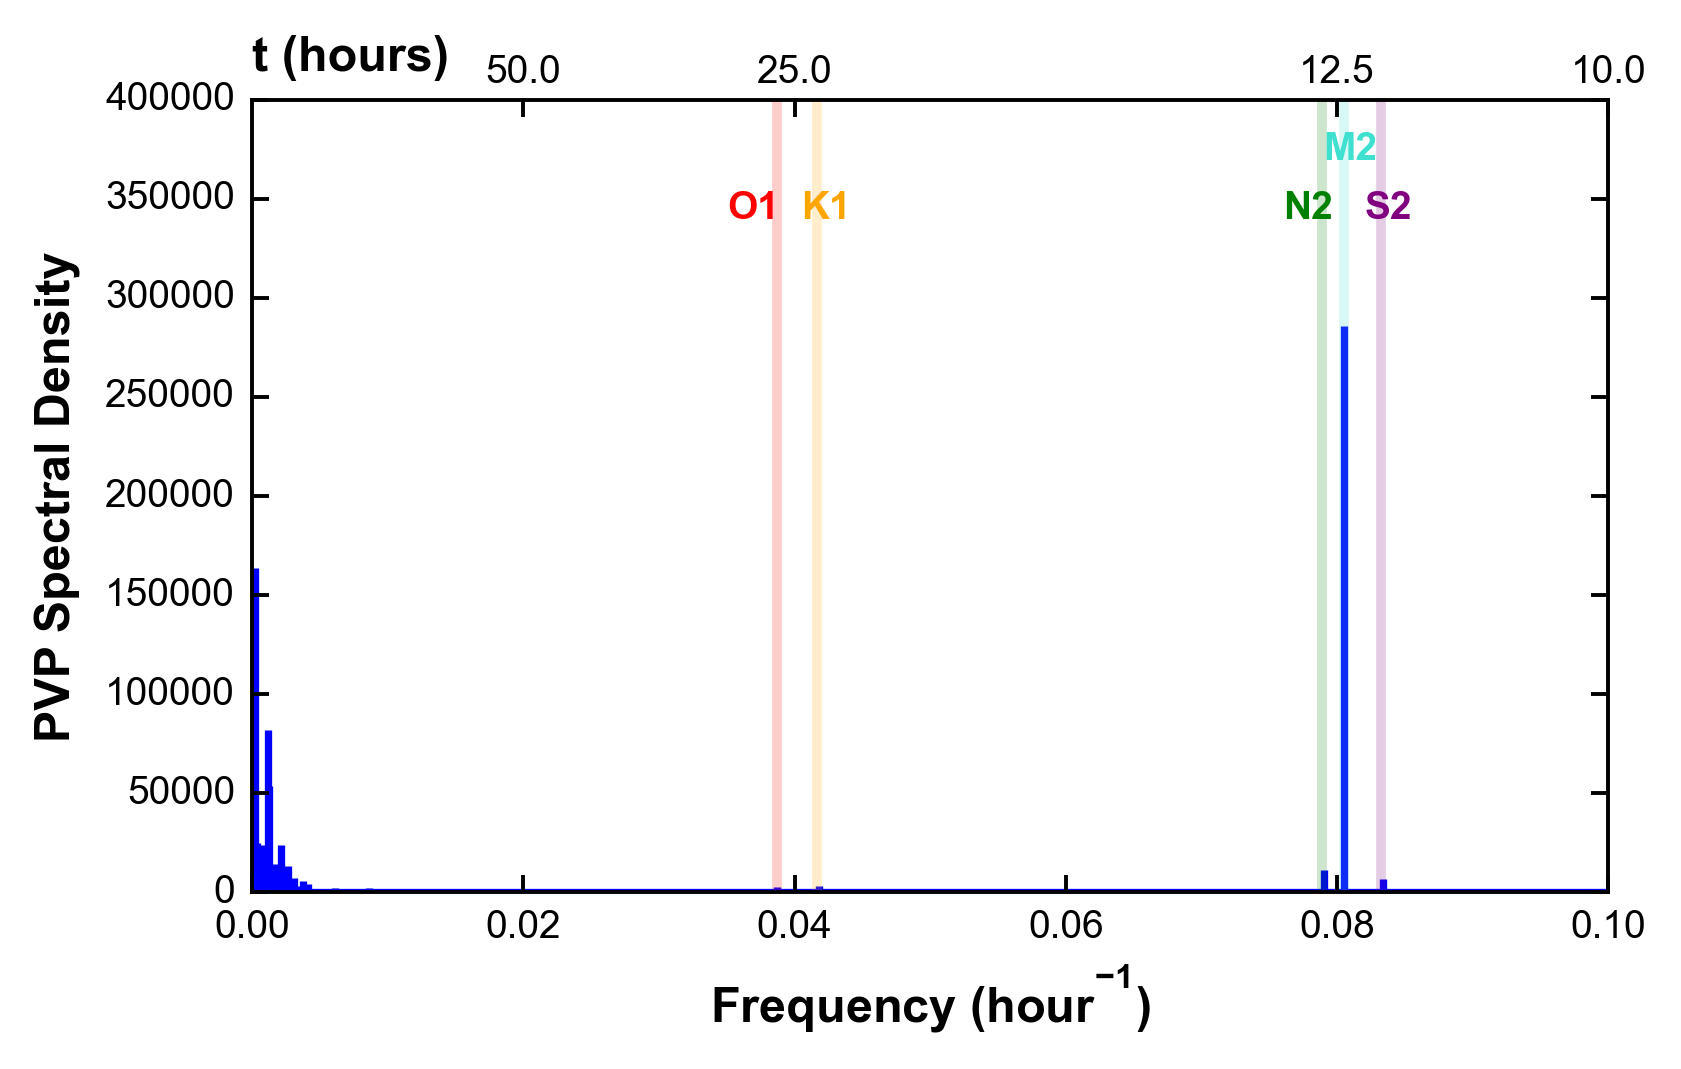

In [5]:
df['PVP'] = df['PVP'].interpolate(method='linear')
nan_true = df['PVP'].isnull().values.any() #check if there are nan values
print('Are there NaN values? ',nan_true)
quantity_nan = df['PVP'].isnull().sum() # how many nan values
print('There are: ', quantity_nan, 'NaN')

short = df.iloc[0:1242,:]
tide = df['PVP']*0.3048
coeff_obs = np.polyfit(df['index'],tide, 1)
print('The linear trend coefficients for observed tide are', coeff_obs[0], 'mm hr-1 and ', coeff_obs[1], 'mm')
print('The linear trend coefficients for observed tide are', coeff_obs[0]*24*365.25, 'mm yr-1 and ', coeff_obs[1], 'mm')
trend_obs = np.polyval(coeff_obs, df['index'])
SL_detrend_obs = np.subtract(tide, trend_obs)

tide_fft_obs = np.fft.fft(SL_detrend_obs)

# Once the FFT has been obtained, square  
# its absolute value in order to get the power spectral density (PSD):
tide_psd_obs = np.abs(tide_fft_obs) ** 2

# The next step is to get the frequencies corresponding to the values of the PSD. 
# The fftfreq() utility function does just that. 
# It takes the length of the PSD vector as input as well as the frequency unit. 
# Here, we choose an annual unit: a frequency of 1 corresponds to 1 year (365.25 days),(1 day = 24 hours). 
# We divide 1/(365.25*24) because the original unit is in hours:
fftfreqs_obs = np.fft.fftfreq(len(tide))

# The fftfreq() function returns positive and negative frequencies. 
# We are only interested in positive frequencies here, as we have a real signal:
i = fftfreqs_obs > 0
print('Fourier Transform')
print(tide_fft_obs[706])
f2_obs = np.log10(tide_psd_obs[i])
print('power spectral density')
print(tide_psd_obs[706])
print('log10 power spectral density')
print(f2_obs[706])
print('frequencies (hour^-1)')
f1_obs=fftfreqs_obs[i]
print(f1_obs[704:710])
print('fft amplitude (m)')
amp_obs = 2.*np.abs(tide_fft_obs[i])/len(tide_fft_obs)
print(amp_obs[706]) 
#print(2.*np.abs(tide_fft[i])/len(tide_fft))
print('periods (hours)')
print(1/f1_obs[706])
print(len(tide_fft_obs[i]))
print(len(fftfreqs_obs[i]))

tide_fft_selected_obs = tide_fft_obs.copy()
tide_fft_selected_obs[np.abs(fftfreqs_obs) >0.0806] = 0
tide_fft_selected_obs[np.abs(fftfreqs_obs) <0.0804] = 0
t_slow_obs = np.real(sp.fftpack.ifft(tide_fft_selected_obs))
np.savetxt('test.csv',t_slow_obs)

vspan_start1 = fftfreqs_obs[fftfreqs_obs==0.08]
vspan_end1 = 1.92
vspan_start2 = 0.099
vspan_end2 = 0.101
xlim_start = 0.000
xlim_end = 0.10

n2 = 0.076
m2 = 0.079
s2 =0.082
k1 = 0.0405
o1 = 0.035
tt1 = 370000
tt =  340000

i = fftfreqs_obs > 0
new_tick_locations = np.array([0.02, 0.04,0.08,0.1])
def tick_function(X):
    V = 1/X
    return ["%.1f" % z for z in V]

plt.figure(figsize=(5,3))

ax = host_subplot(111, axes_class=AA.Axes)
ax.set_xlim([0,xlim_end])
ax.set_ylim([0,400000])
ax.set_xlabel('Frequency ($\mathregular{hour^{-1}}$)')
ax.set_ylabel('PVP Spectral Density')
ax.set_title('t (hours)', loc='left')
ax2 = ax.twin() # ax2 is responsible for "top" axis and "right" axis
ax2.axis["top"].major_ticklabels.set_visible(True)
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tick_function(new_tick_locations))
plt.stem(fftfreqs_obs[i], tide_psd_obs[i], 'b', \
         markerfmt=" ", basefmt="-b")
ax.axvline(x = fftfreqs_obs[366],linewidth=2,linestyle= '-', color= 'orange', alpha=0.2)
ax.axvline(x = fftfreqs_obs[693],linewidth=2,linestyle= '-', color= 'green', alpha=0.2)
ax.axvline(x = fftfreqs_obs[707],linewidth=2,linestyle= '-', color= 'turquoise', alpha=0.2)
ax.axvline(x = fftfreqs_obs[731],linewidth=2,linestyle= '-', color= 'purple', alpha=0.2)
ax.axvline(x = fftfreqs_obs[340],linewidth=2,linestyle= '-', color= 'red', alpha=0.2)
ax.text(n2, tt, 'N2',color='green', size=8, weight='heavy')
ax.text(m2, tt1, 'M2',color='turquoise', size=8, weight='heavy')
ax.text(s2,tt, 'S2',color='purple', size=8, weight='heavy')
ax.text(k1, tt, 'K1',color='orange', size=8, weight='heavy')
ax.text(o1, tt, 'O1',color='red', size=8, weight='heavy')

Are there NaN values?  False
There are:  0 NaN
The linear trend coefficients for observed tide are -2.5116217518283233e-05 mm hr-1 and  0.06775654242671271 mm
The linear trend coefficients for observed tide are -0.2201687627652708 mm yr-1 and  0.06775654242671271 mm
Fourier Transform
(-31.984469133123035+45.4725250445657j)
power spectral density
3090.7567996563557
log10 power spectral density
6.221073787976091
frequencies (hour^-1)
[0.08027784 0.08039171 0.08050558 0.08061945 0.08073332 0.08084719]
fft amplitude (m)
0.29374701148111126
periods (hours)
12.421499292786422
4390
4390


Text(0.035, 1700000, 'O1')

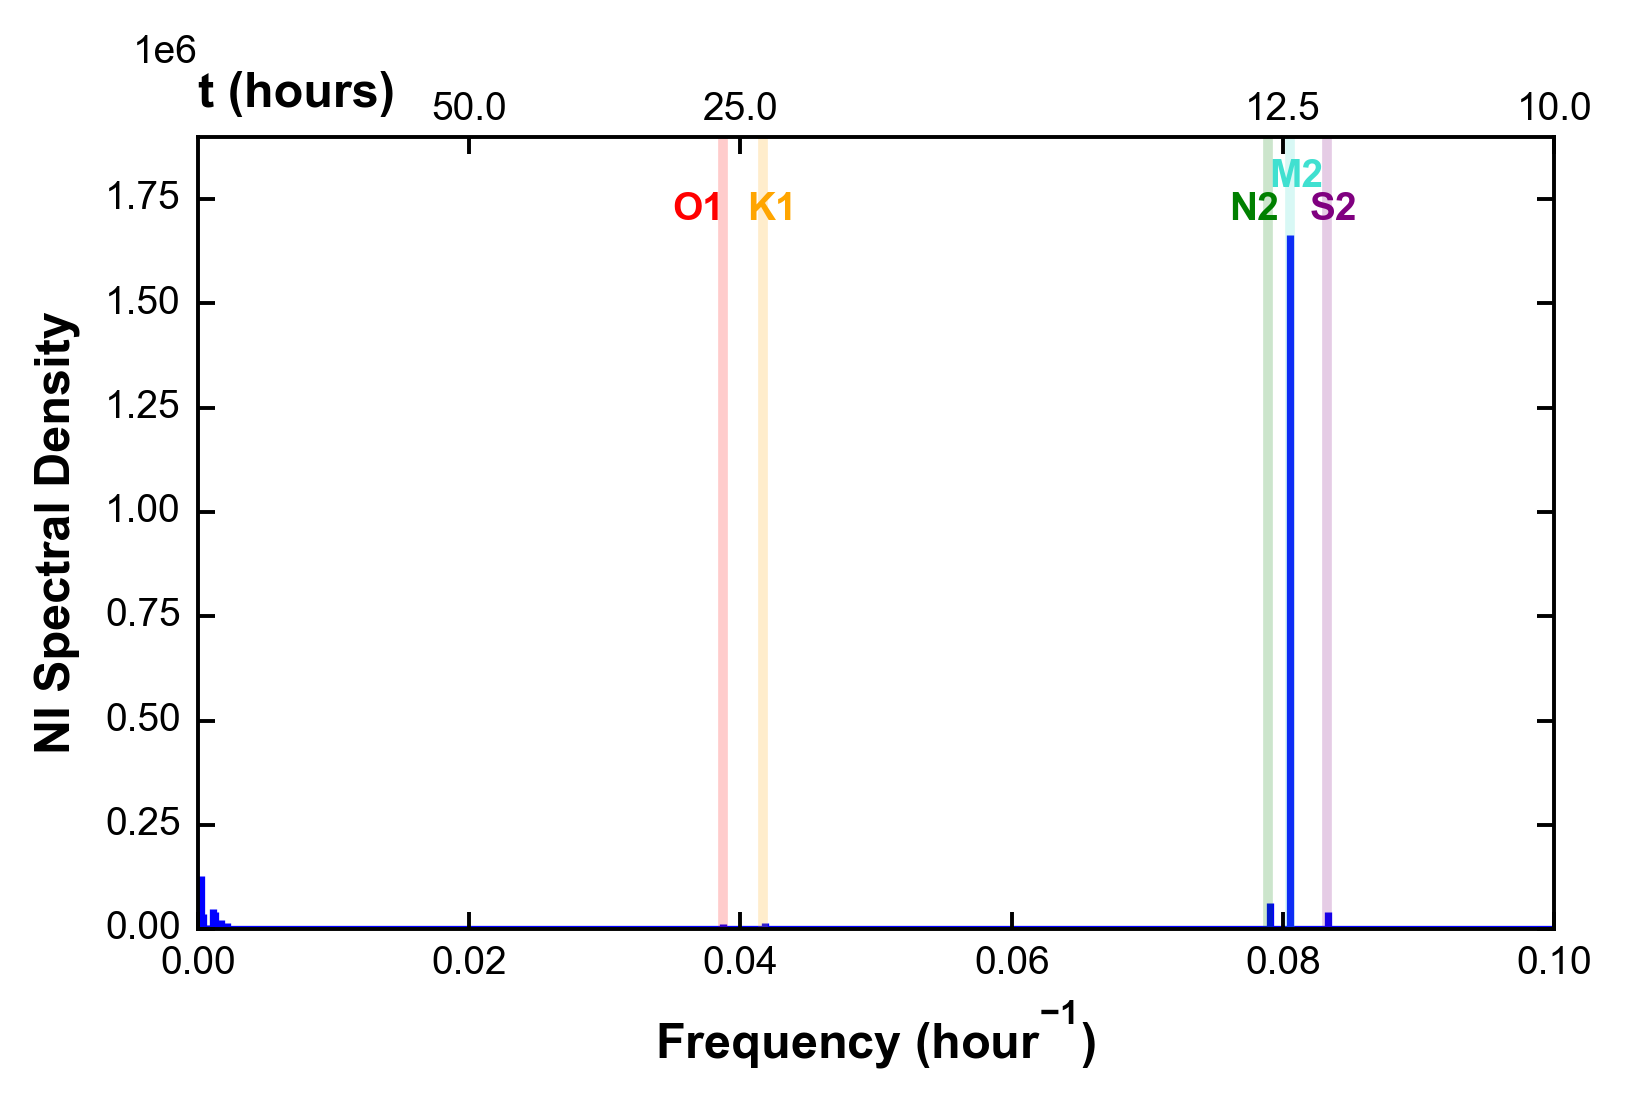

In [6]:
df['NI'] = df['NI'].interpolate(method='linear')
nan_true = df['NI'].isnull().values.any() #check if there are nan values
print('Are there NaN values? ',nan_true)
quantity_nan = df['NI'].isnull().sum() # how many nan values
print('There are: ', quantity_nan, 'NaN')

short = df.iloc[0:1242,:]
tide = df['NI']*0.3048
coeff_obs = np.polyfit(df['index'],tide, 1)
print('The linear trend coefficients for observed tide are', coeff_obs[0], 'mm hr-1 and ', coeff_obs[1], 'mm')
print('The linear trend coefficients for observed tide are', coeff_obs[0]*24*365.25, 'mm yr-1 and ', coeff_obs[1], 'mm')
trend_obs = np.polyval(coeff_obs, df['index'])
SL_detrend_obs = np.subtract(tide, trend_obs)

tide_fft_obs = np.fft.fft(SL_detrend_obs)

# Once the FFT has been obtained, square  
# its absolute value in order to get the power spectral density (PSD):
tide_psd_obs = np.abs(tide_fft_obs) ** 2

# The next step is to get the frequencies corresponding to the values of the PSD. 
# The fftfreq() utility function does just that. 
# It takes the length of the PSD vector as input as well as the frequency unit. 
# Here, we choose an annual unit: a frequency of 1 corresponds to 1 year (365.25 days),(1 day = 24 hours). 
# We divide 1/(365.25*24) because the original unit is in hours:
fftfreqs_obs = np.fft.fftfreq(len(tide))

# The fftfreq() function returns positive and negative frequencies. 
# We are only interested in positive frequencies here, as we have a real signal:
i = fftfreqs_obs > 0
print('Fourier Transform')
print(tide_fft_obs[706])
f2_obs = np.log10(tide_psd_obs[i])
print('power spectral density')
print(tide_psd_obs[706])
print('log10 power spectral density')
print(f2_obs[706])
print('frequencies (hour^-1)')
f1_obs=fftfreqs_obs[i]
print(f1_obs[704:710])
print('fft amplitude (m)')
amp_obs = 2.*np.abs(tide_fft_obs[i])/len(tide_fft_obs)
print(amp_obs[706]) 
#print(2.*np.abs(tide_fft[i])/len(tide_fft))
print('periods (hours)')
print(1/f1_obs[706])
print(len(tide_fft_obs[i]))
print(len(fftfreqs_obs[i]))

tide_fft_selected_obs = tide_fft_obs.copy()
tide_fft_selected_obs[np.abs(fftfreqs_obs) >0.0806] = 0
tide_fft_selected_obs[np.abs(fftfreqs_obs) <0.0804] = 0
t_slow_obs = np.real(sp.fftpack.ifft(tide_fft_selected_obs))
np.savetxt('test.csv',t_slow_obs)

vspan_start1 = fftfreqs_obs[fftfreqs_obs==0.08]
vspan_end1 = 1.92
vspan_start2 = 0.099
vspan_end2 = 0.101
xlim_start = 0.000
xlim_end = 0.10

n2 = 0.076
m2 = 0.079
s2 =0.082
k1 = 0.0405
o1 = 0.035
tt1 = 1780000
tt =  1700000

i = fftfreqs_obs > 0
new_tick_locations = np.array([0.02, 0.04,0.08,0.1])
def tick_function(X):
    V = 1/X
    return ["%.1f" % z for z in V]

plt.figure(figsize=(5,3))

ax = host_subplot(111, axes_class=AA.Axes)
ax.set_xlim([0,xlim_end])
ax.set_ylim([0,1900000])
ax.set_xlabel('Frequency ($\mathregular{hour^{-1}}$)')
ax.set_ylabel('NI Spectral Density')
ax.set_title('t (hours)', loc='left')
ax2 = ax.twin() # ax2 is responsible for "top" axis and "right" axis
ax2.axis["top"].major_ticklabels.set_visible(True)
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tick_function(new_tick_locations))
plt.stem(fftfreqs_obs[i], tide_psd_obs[i], 'b', \
         markerfmt=" ", basefmt="-b")
ax.axvline(x = fftfreqs_obs[366],linewidth=2,linestyle= '-', color= 'orange', alpha=0.2)
ax.axvline(x = fftfreqs_obs[693],linewidth=2,linestyle= '-', color= 'green', alpha=0.2)
ax.axvline(x = fftfreqs_obs[707],linewidth=2,linestyle= '-', color= 'turquoise', alpha=0.2)
ax.axvline(x = fftfreqs_obs[731],linewidth=2,linestyle= '-', color= 'purple', alpha=0.2)
ax.axvline(x = fftfreqs_obs[340],linewidth=2,linestyle= '-', color= 'red', alpha=0.2)
ax.text(n2, tt, 'N2',color='green', size=8, weight='heavy')
ax.text(m2, tt1, 'M2',color='turquoise', size=8, weight='heavy')
ax.text(s2,tt, 'S2',color='purple', size=8, weight='heavy')
ax.text(k1, tt, 'K1',color='orange', size=8, weight='heavy')
ax.text(o1, tt, 'O1',color='red', size=8, weight='heavy')

Are there NaN values?  False
There are:  0 NaN
The linear trend coefficients for observed tide are -2.448969422852433e-05 mm hr-1 and  0.22805182037582394 mm
The linear trend coefficients for observed tide are -0.21467665960724427 mm yr-1 and  0.22805182037582394 mm
Fourier Transform
(-21.259846422848312+28.46875760027048j)
power spectral density
1262.4512292260542
log10 power spectral density
5.797423526745579
frequencies (hour^-1)
[0.08027784 0.08039171 0.08050558 0.08061945 0.08073332 0.08084719]
fft amplitude (m)
0.18036336376271858
periods (hours)
12.421499292786422
4390
4390


Text(0.035, 720000, 'O1')

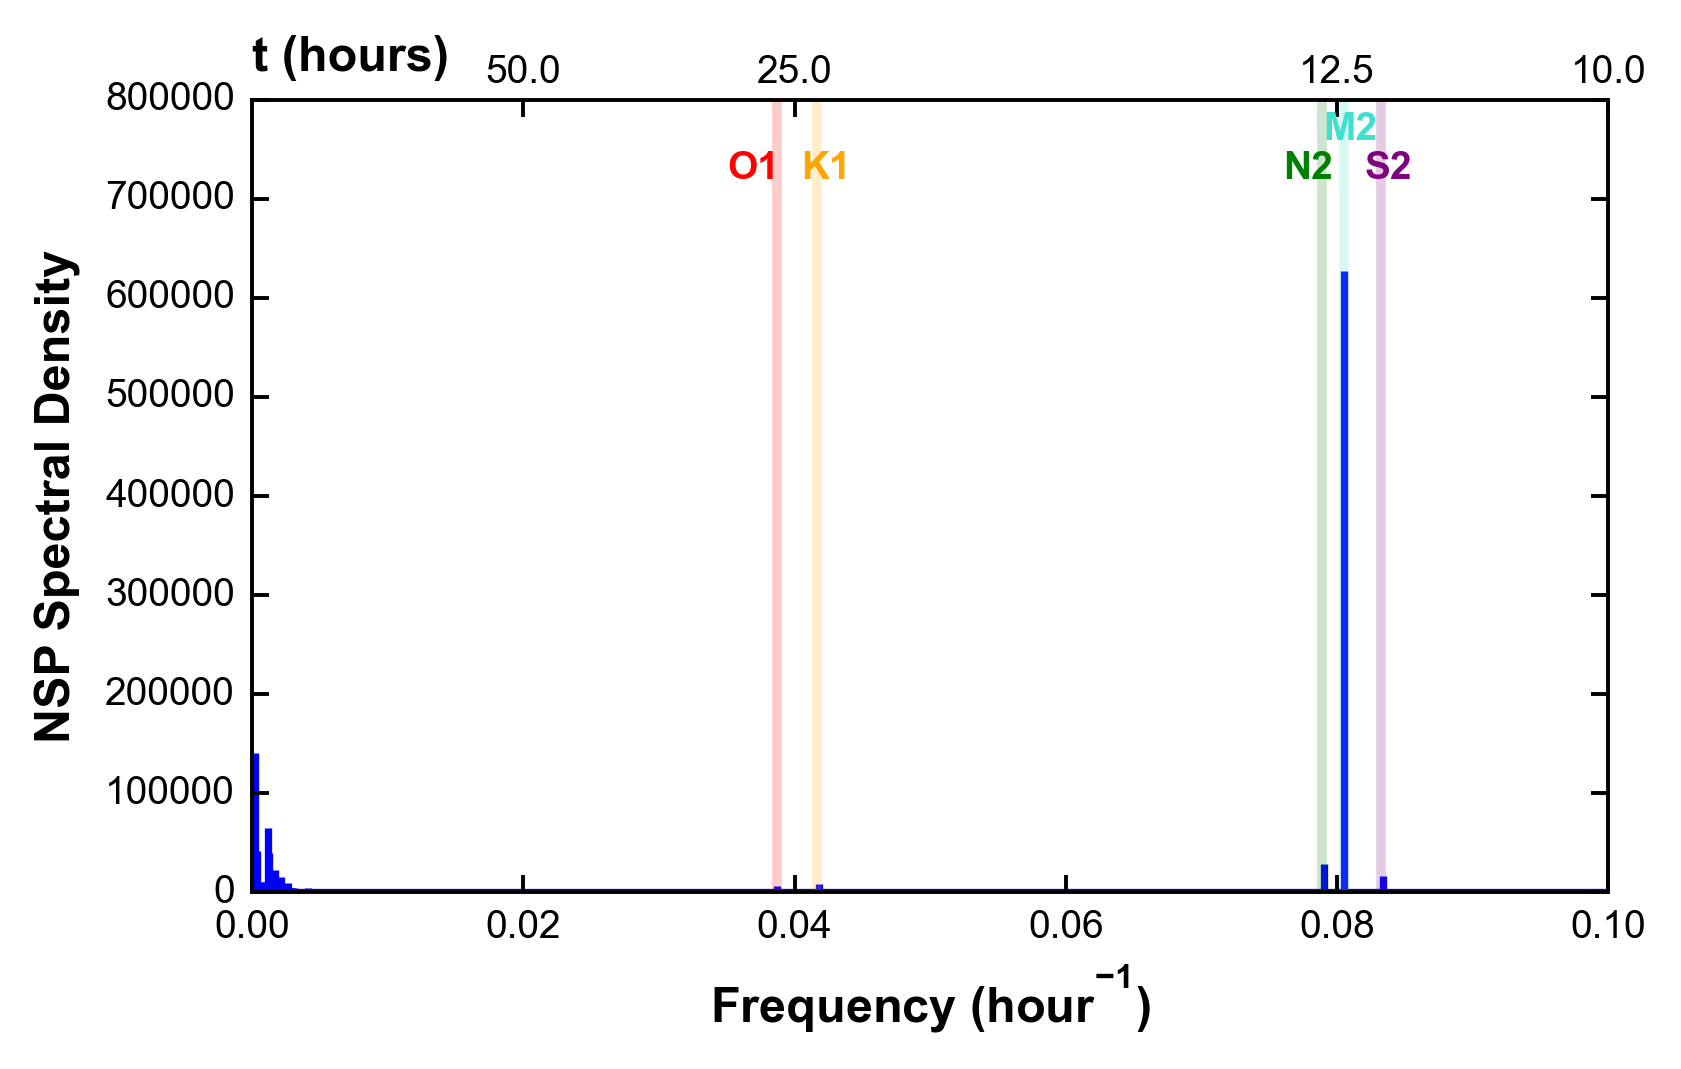

In [7]:
df['NSP'] = df['NSP'].interpolate(method='linear')
nan_true = df['NSP'].isnull().values.any() #check if there are nan values
print('Are there NaN values? ',nan_true)
quantity_nan = df['NSP'].isnull().sum() # how many nan values
print('There are: ', quantity_nan, 'NaN')

short = df.iloc[0:1242,:]
tide = df['NSP']*0.3048
coeff_obs = np.polyfit(df['index'],tide, 1)
print('The linear trend coefficients for observed tide are', coeff_obs[0], 'mm hr-1 and ', coeff_obs[1], 'mm')
print('The linear trend coefficients for observed tide are', coeff_obs[0]*24*365.25, 'mm yr-1 and ', coeff_obs[1], 'mm')
trend_obs = np.polyval(coeff_obs, df['index'])
SL_detrend_obs = np.subtract(tide, trend_obs)

tide_fft_obs = np.fft.fft(SL_detrend_obs)

# Once the FFT has been obtained, square  
# its absolute value in order to get the power spectral density (PSD):
tide_psd_obs = np.abs(tide_fft_obs) ** 2

# The next step is to get the frequencies corresponding to the values of the PSD. 
# The fftfreq() utility function does just that. 
# It takes the length of the PSD vector as input as well as the frequency unit. 
# Here, we choose an annual unit: a frequency of 1 corresponds to 1 year (365.25 days),(1 day = 24 hours). 
# We divide 1/(365.25*24) because the original unit is in hours:
fftfreqs_obs = np.fft.fftfreq(len(tide))

# The fftfreq() function returns positive and negative frequencies. 
# We are only interested in positive frequencies here, as we have a real signal:
i = fftfreqs_obs > 0
print('Fourier Transform')
print(tide_fft_obs[706])
f2_obs = np.log10(tide_psd_obs[i])
print('power spectral density')
print(tide_psd_obs[706])
print('log10 power spectral density')
print(f2_obs[706])
print('frequencies (hour^-1)')
f1_obs=fftfreqs_obs[i]
print(f1_obs[704:710])
print('fft amplitude (m)')
amp_obs = 2.*np.abs(tide_fft_obs[i])/len(tide_fft_obs)
print(amp_obs[706]) 
#print(2.*np.abs(tide_fft[i])/len(tide_fft))
print('periods (hours)')
print(1/f1_obs[706])
print(len(tide_fft_obs[i]))
print(len(fftfreqs_obs[i]))

tide_fft_selected_obs = tide_fft_obs.copy()
tide_fft_selected_obs[np.abs(fftfreqs_obs) >0.0806] = 0
tide_fft_selected_obs[np.abs(fftfreqs_obs) <0.0804] = 0
t_slow_obs = np.real(sp.fftpack.ifft(tide_fft_selected_obs))
np.savetxt('test.csv',t_slow_obs)

vspan_start1 = fftfreqs_obs[fftfreqs_obs==0.08]
vspan_end1 = 1.92
vspan_start2 = 0.099
vspan_end2 = 0.101
xlim_start = 0.000
xlim_end = 0.10

n2 = 0.076
m2 = 0.079
s2 =0.082
k1 = 0.0405
o1 = 0.035
tt1 = 760000
tt =  720000

i = fftfreqs_obs > 0
new_tick_locations = np.array([0.02, 0.04,0.08,0.1])
def tick_function(X):
    V = 1/X
    return ["%.1f" % z for z in V]

plt.figure(figsize=(5,3))

ax = host_subplot(111, axes_class=AA.Axes)
ax.set_xlim([0,xlim_end])
ax.set_ylim([0,800000])
ax.set_xlabel('Frequency ($\mathregular{hour^{-1}}$)')
ax.set_ylabel('NSP Spectral Density')
ax.set_title('t (hours)', loc='left')
ax2 = ax.twin() # ax2 is responsible for "top" axis and "right" axis
ax2.axis["top"].major_ticklabels.set_visible(True)
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tick_function(new_tick_locations))
plt.stem(fftfreqs_obs[i], tide_psd_obs[i], 'b', \
         markerfmt=" ", basefmt="-b")
ax.axvline(x = fftfreqs_obs[366],linewidth=2,linestyle= '-', color= 'orange', alpha=0.2)
ax.axvline(x = fftfreqs_obs[693],linewidth=2,linestyle= '-', color= 'green', alpha=0.2)
ax.axvline(x = fftfreqs_obs[707],linewidth=2,linestyle= '-', color= 'turquoise', alpha=0.2)
ax.axvline(x = fftfreqs_obs[731],linewidth=2,linestyle= '-', color= 'purple', alpha=0.2)
ax.axvline(x = fftfreqs_obs[340],linewidth=2,linestyle= '-', color= 'red', alpha=0.2)
ax.text(n2, tt, 'N2',color='green', size=8, weight='heavy')
ax.text(m2, tt1, 'M2',color='turquoise', size=8, weight='heavy')
ax.text(s2,tt, 'S2',color='purple', size=8, weight='heavy')
ax.text(k1, tt, 'K1',color='orange', size=8, weight='heavy')
ax.text(o1, tt, 'O1',color='red', size=8, weight='heavy')

Are there NaN values?  False
There are:  0 NaN
The linear trend coefficients for observed tide are -2.2653484035253452e-05 mm hr-1 and  0.15169183594701 mm
The linear trend coefficients for observed tide are -0.19858044105303177 mm yr-1 and  0.15169183594701 mm
Fourier Transform
(-10.732901649124791+24.82288449000054j)
power spectral density
731.3707722136951
log10 power spectral density
5.67414596589322
frequencies (hour^-1)
[0.08027784 0.08039171 0.08050558 0.08061945 0.08073332 0.08084719]
fft amplitude (m)
0.15649827173453673
periods (hours)
12.421499292786422
4390
4390


Text(0.035, 520000, 'O1')

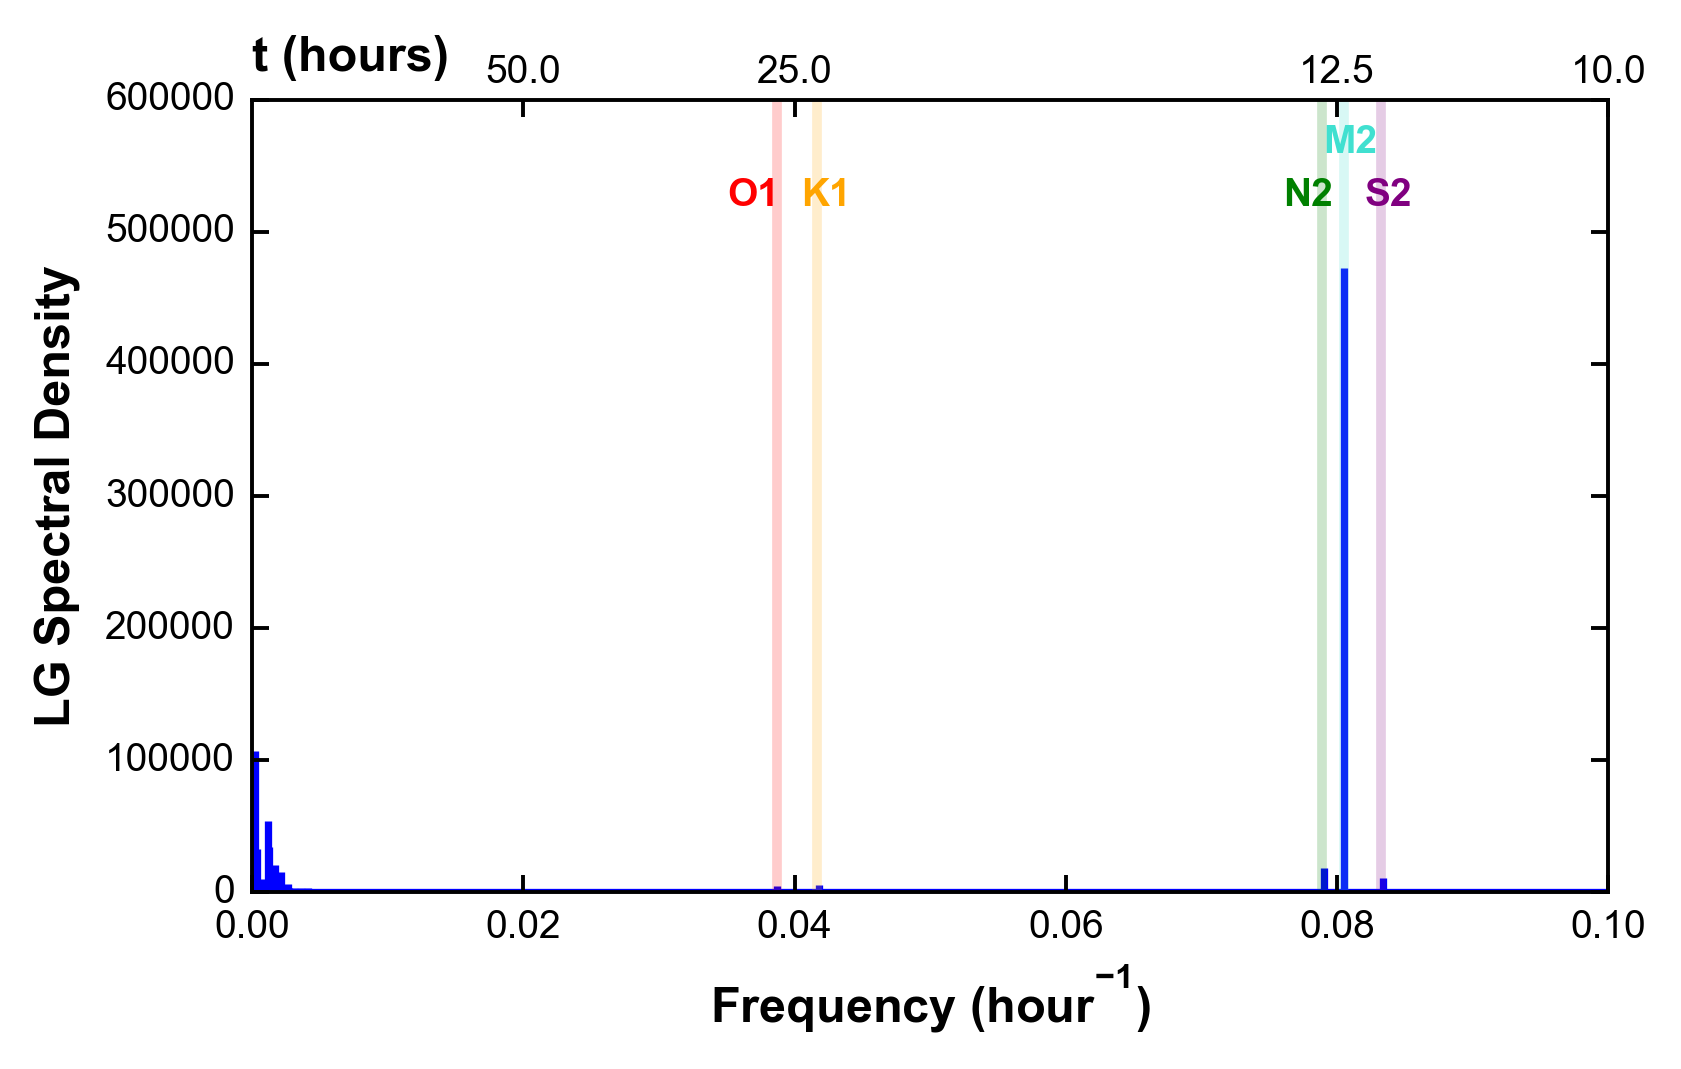

In [8]:
df['LG'] = df['LG'].interpolate(method='linear')
nan_true = df['LG'].isnull().values.any() #check if there are nan values
print('Are there NaN values? ',nan_true)
quantity_nan = df['LG'].isnull().sum() # how many nan values
print('There are: ', quantity_nan, 'NaN')

short = df.iloc[0:1242,:]
tide = df['LG']*0.3048
coeff_obs = np.polyfit(df['index'],tide, 1)
print('The linear trend coefficients for observed tide are', coeff_obs[0], 'mm hr-1 and ', coeff_obs[1], 'mm')
print('The linear trend coefficients for observed tide are', coeff_obs[0]*24*365.25, 'mm yr-1 and ', coeff_obs[1], 'mm')
trend_obs = np.polyval(coeff_obs, df['index'])
SL_detrend_obs = np.subtract(tide, trend_obs)

tide_fft_obs = np.fft.fft(SL_detrend_obs)

# Once the FFT has been obtained, square  
# its absolute value in order to get the power spectral density (PSD):
tide_psd_obs = np.abs(tide_fft_obs) ** 2

# The next step is to get the frequencies corresponding to the values of the PSD. 
# The fftfreq() utility function does just that. 
# It takes the length of the PSD vector as input as well as the frequency unit. 
# Here, we choose an annual unit: a frequency of 1 corresponds to 1 year (365.25 days),(1 day = 24 hours). 
# We divide 1/(365.25*24) because the original unit is in hours:
fftfreqs_obs = np.fft.fftfreq(len(tide))

# The fftfreq() function returns positive and negative frequencies. 
# We are only interested in positive frequencies here, as we have a real signal:
i = fftfreqs_obs > 0
print('Fourier Transform')
print(tide_fft_obs[706])
f2_obs = np.log10(tide_psd_obs[i])
print('power spectral density')
print(tide_psd_obs[706])
print('log10 power spectral density')
print(f2_obs[706])
print('frequencies (hour^-1)')
f1_obs=fftfreqs_obs[i]
print(f1_obs[704:710])
print('fft amplitude (m)')
amp_obs = 2.*np.abs(tide_fft_obs[i])/len(tide_fft_obs)
print(amp_obs[706]) 
#print(2.*np.abs(tide_fft[i])/len(tide_fft))
print('periods (hours)')
print(1/f1_obs[706])
print(len(tide_fft_obs[i]))
print(len(fftfreqs_obs[i]))

tide_fft_selected_obs = tide_fft_obs.copy()
tide_fft_selected_obs[np.abs(fftfreqs_obs) >0.0806] = 0
tide_fft_selected_obs[np.abs(fftfreqs_obs) <0.0804] = 0
t_slow_obs = np.real(sp.fftpack.ifft(tide_fft_selected_obs))
np.savetxt('test.csv',t_slow_obs)

vspan_start1 = fftfreqs_obs[fftfreqs_obs==0.08]
vspan_end1 = 1.92
vspan_start2 = 0.099
vspan_end2 = 0.101
xlim_start = 0.000
xlim_end = 0.10

n2 = 0.076
m2 = 0.079
s2 =0.082
k1 = 0.0405
o1 = 0.035
tt1 = 560000
tt =  520000

i = fftfreqs_obs > 0
new_tick_locations = np.array([0.02, 0.04,0.08,0.1])
def tick_function(X):
    V = 1/X
    return ["%.1f" % z for z in V]

plt.figure(figsize=(5,3))

ax = host_subplot(111, axes_class=AA.Axes)
ax.set_xlim([0,xlim_end])
ax.set_ylim([0,600000])
ax.set_xlabel('Frequency ($\mathregular{hour^{-1}}$)')
ax.set_ylabel('LG Spectral Density')
ax.set_title('t (hours)', loc='left')
ax2 = ax.twin() # ax2 is responsible for "top" axis and "right" axis
ax2.axis["top"].major_ticklabels.set_visible(True)
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tick_function(new_tick_locations))
plt.stem(fftfreqs_obs[i], tide_psd_obs[i], 'b', \
         markerfmt=" ", basefmt="-b")
ax.axvline(x = fftfreqs_obs[366],linewidth=2,linestyle= '-', color= 'orange', alpha=0.2)
ax.axvline(x = fftfreqs_obs[693],linewidth=2,linestyle= '-', color= 'green', alpha=0.2)
ax.axvline(x = fftfreqs_obs[707],linewidth=2,linestyle= '-', color= 'turquoise', alpha=0.2)
ax.axvline(x = fftfreqs_obs[731],linewidth=2,linestyle= '-', color= 'purple', alpha=0.2)
ax.axvline(x = fftfreqs_obs[340],linewidth=2,linestyle= '-', color= 'red', alpha=0.2)
ax.text(n2, tt, 'N2',color='green', size=8, weight='heavy')
ax.text(m2, tt1, 'M2',color='turquoise', size=8, weight='heavy')
ax.text(s2,tt, 'S2',color='purple', size=8, weight='heavy')
ax.text(k1, tt, 'K1',color='orange', size=8, weight='heavy')
ax.text(o1, tt, 'O1',color='red', size=8, weight='heavy')

Are there NaN values?  False
There are:  0 NaN
The linear trend coefficients for observed tide are -2.45937074497876e-05 mm hr-1 and  0.19907710366041317 mm
The linear trend coefficients for observed tide are -0.21558843950483808 mm yr-1 and  0.19907710366041317 mm
Fourier Transform
(-16.736061378376277+26.037544695633446j)
power spectral density
958.0494842378874
log10 power spectral density
5.771869732222243
frequencies (hour^-1)
[0.08027784 0.08039171 0.08050558 0.08061945 0.08073332 0.08084719]
fft amplitude (m)
0.17513438797128522
periods (hours)
12.421499292786422
4390
4390


Text(0.035, 720000, 'O1')

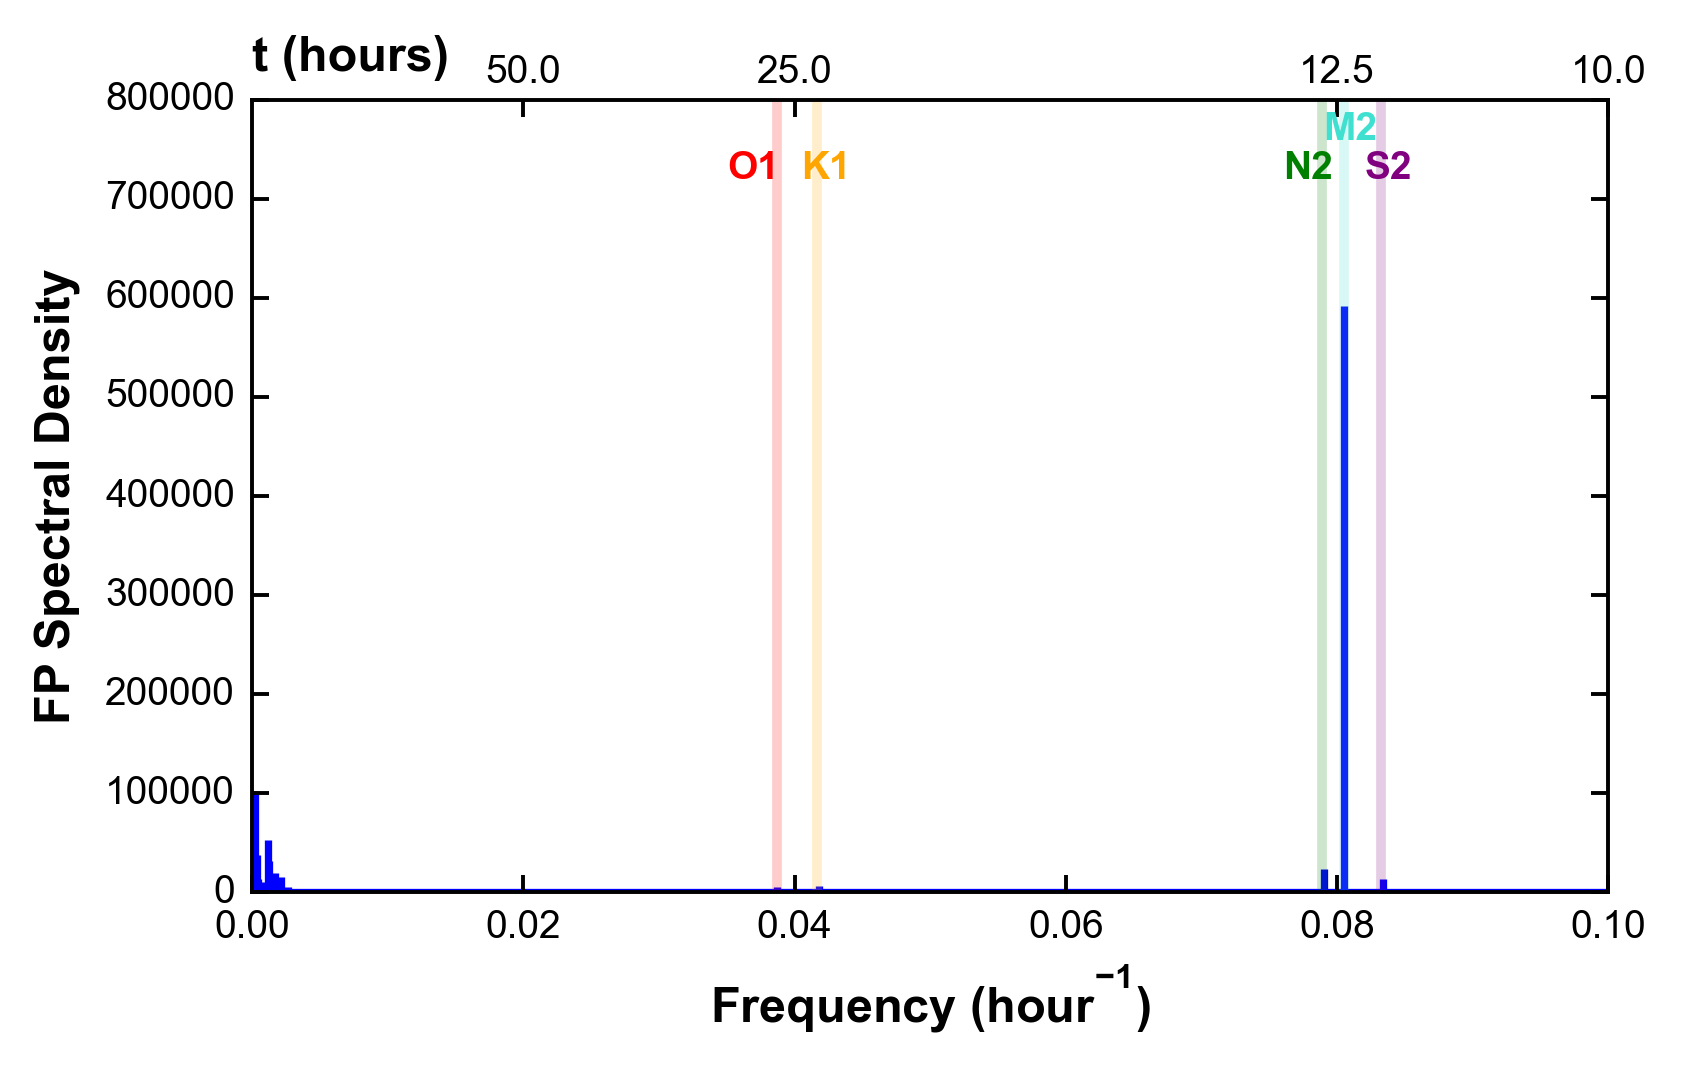

In [9]:
df['FP'] = df['FP'].interpolate(method='linear')
nan_true = df['FP'].isnull().values.any() #check if there are nan values
print('Are there NaN values? ',nan_true)
quantity_nan = df['FP'].isnull().sum() # how many nan values
print('There are: ', quantity_nan, 'NaN')

short = df.iloc[0:1242,:]
tide = df['FP']*0.3048
coeff_obs = np.polyfit(df['index'],tide, 1)
print('The linear trend coefficients for observed tide are', coeff_obs[0], 'mm hr-1 and ', coeff_obs[1], 'mm')
print('The linear trend coefficients for observed tide are', coeff_obs[0]*24*365.25, 'mm yr-1 and ', coeff_obs[1], 'mm')
trend_obs = np.polyval(coeff_obs, df['index'])
SL_detrend_obs = np.subtract(tide, trend_obs)

tide_fft_obs = np.fft.fft(SL_detrend_obs)

# Once the FFT has been obtained, square  
# its absolute value in order to get the power spectral density (PSD):
tide_psd_obs = np.abs(tide_fft_obs) ** 2

# The next step is to get the frequencies corresponding to the values of the PSD. 
# The fftfreq() utility function does just that. 
# It takes the length of the PSD vector as input as well as the frequency unit. 
# Here, we choose an annual unit: a frequency of 1 corresponds to 1 year (365.25 days),(1 day = 24 hours). 
# We divide 1/(365.25*24) because the original unit is in hours:
fftfreqs_obs = np.fft.fftfreq(len(tide))

# The fftfreq() function returns positive and negative frequencies. 
# We are only interested in positive frequencies here, as we have a real signal:
i = fftfreqs_obs > 0
print('Fourier Transform')
print(tide_fft_obs[706])
f2_obs = np.log10(tide_psd_obs[i])
print('power spectral density')
print(tide_psd_obs[706])
print('log10 power spectral density')
print(f2_obs[706])
print('frequencies (hour^-1)')
f1_obs=fftfreqs_obs[i]
print(f1_obs[704:710])
print('fft amplitude (m)')
amp_obs = 2.*np.abs(tide_fft_obs[i])/len(tide_fft_obs)
print(amp_obs[706]) 
#print(2.*np.abs(tide_fft[i])/len(tide_fft))
print('periods (hours)')
print(1/f1_obs[706])
print(len(tide_fft_obs[i]))
print(len(fftfreqs_obs[i]))

tide_fft_selected_obs = tide_fft_obs.copy()
tide_fft_selected_obs[np.abs(fftfreqs_obs) >0.0806] = 0
tide_fft_selected_obs[np.abs(fftfreqs_obs) <0.0804] = 0
t_slow_obs = np.real(sp.fftpack.ifft(tide_fft_selected_obs))
np.savetxt('test.csv',t_slow_obs)

vspan_start1 = fftfreqs_obs[fftfreqs_obs==0.08]
vspan_end1 = 1.92
vspan_start2 = 0.099
vspan_end2 = 0.101
xlim_start = 0.000
xlim_end = 0.10

n2 = 0.076
m2 = 0.079
s2 =0.082
k1 = 0.0405
o1 = 0.035
tt1 = 760000
tt =  720000

i = fftfreqs_obs > 0
new_tick_locations = np.array([0.02, 0.04,0.08,0.1])
def tick_function(X):
    V = 1/X
    return ["%.1f" % z for z in V]

plt.figure(figsize=(5,3))

ax = host_subplot(111, axes_class=AA.Axes)
ax.set_xlim([0,xlim_end])
ax.set_ylim([0,800000])
ax.set_xlabel('Frequency ($\mathregular{hour^{-1}}$)')
ax.set_ylabel('FP Spectral Density')
ax.set_title('t (hours)', loc='left')
ax2 = ax.twin() # ax2 is responsible for "top" axis and "right" axis
ax2.axis["top"].major_ticklabels.set_visible(True)
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tick_function(new_tick_locations))
plt.stem(fftfreqs_obs[i], tide_psd_obs[i], 'b', \
         markerfmt=" ", basefmt="-b")
ax.axvline(x = fftfreqs_obs[366],linewidth=2,linestyle= '-', color= 'orange', alpha=0.2)
ax.axvline(x = fftfreqs_obs[693],linewidth=2,linestyle= '-', color= 'green', alpha=0.2)
ax.axvline(x = fftfreqs_obs[707],linewidth=2,linestyle= '-', color= 'turquoise', alpha=0.2)
ax.axvline(x = fftfreqs_obs[731],linewidth=2,linestyle= '-', color= 'purple', alpha=0.2)
ax.axvline(x = fftfreqs_obs[340],linewidth=2,linestyle= '-', color= 'red', alpha=0.2)
ax.text(n2, tt, 'N2',color='green', size=8, weight='heavy')
ax.text(m2, tt1, 'M2',color='turquoise', size=8, weight='heavy')
ax.text(s2,tt, 'S2',color='purple', size=8, weight='heavy')
ax.text(k1, tt, 'K1',color='orange', size=8, weight='heavy')
ax.text(o1, tt, 'O1',color='red', size=8, weight='heavy')

Are there NaN values?  False
There are:  0 NaN
The linear trend coefficients for observed tide are -2.3048285985684167e-05 mm hr-1 and  0.17761542105575626 mm
The linear trend coefficients for observed tide are -0.20204127495050742 mm yr-1 and  0.17761542105575626 mm
Fourier Transform
(-17.75447517307372+28.008175171139765j)
power spectral density
1099.6792650885407
log10 power spectral density
5.7083179815588
frequencies (hour^-1)
[0.08027784 0.08039171 0.08050558 0.08061945 0.08073332 0.08084719]
fft amplitude (m)
0.1627779421035001
periods (hours)
12.421499292786422
4390
4390


Text(0.035, 520000, 'O1')

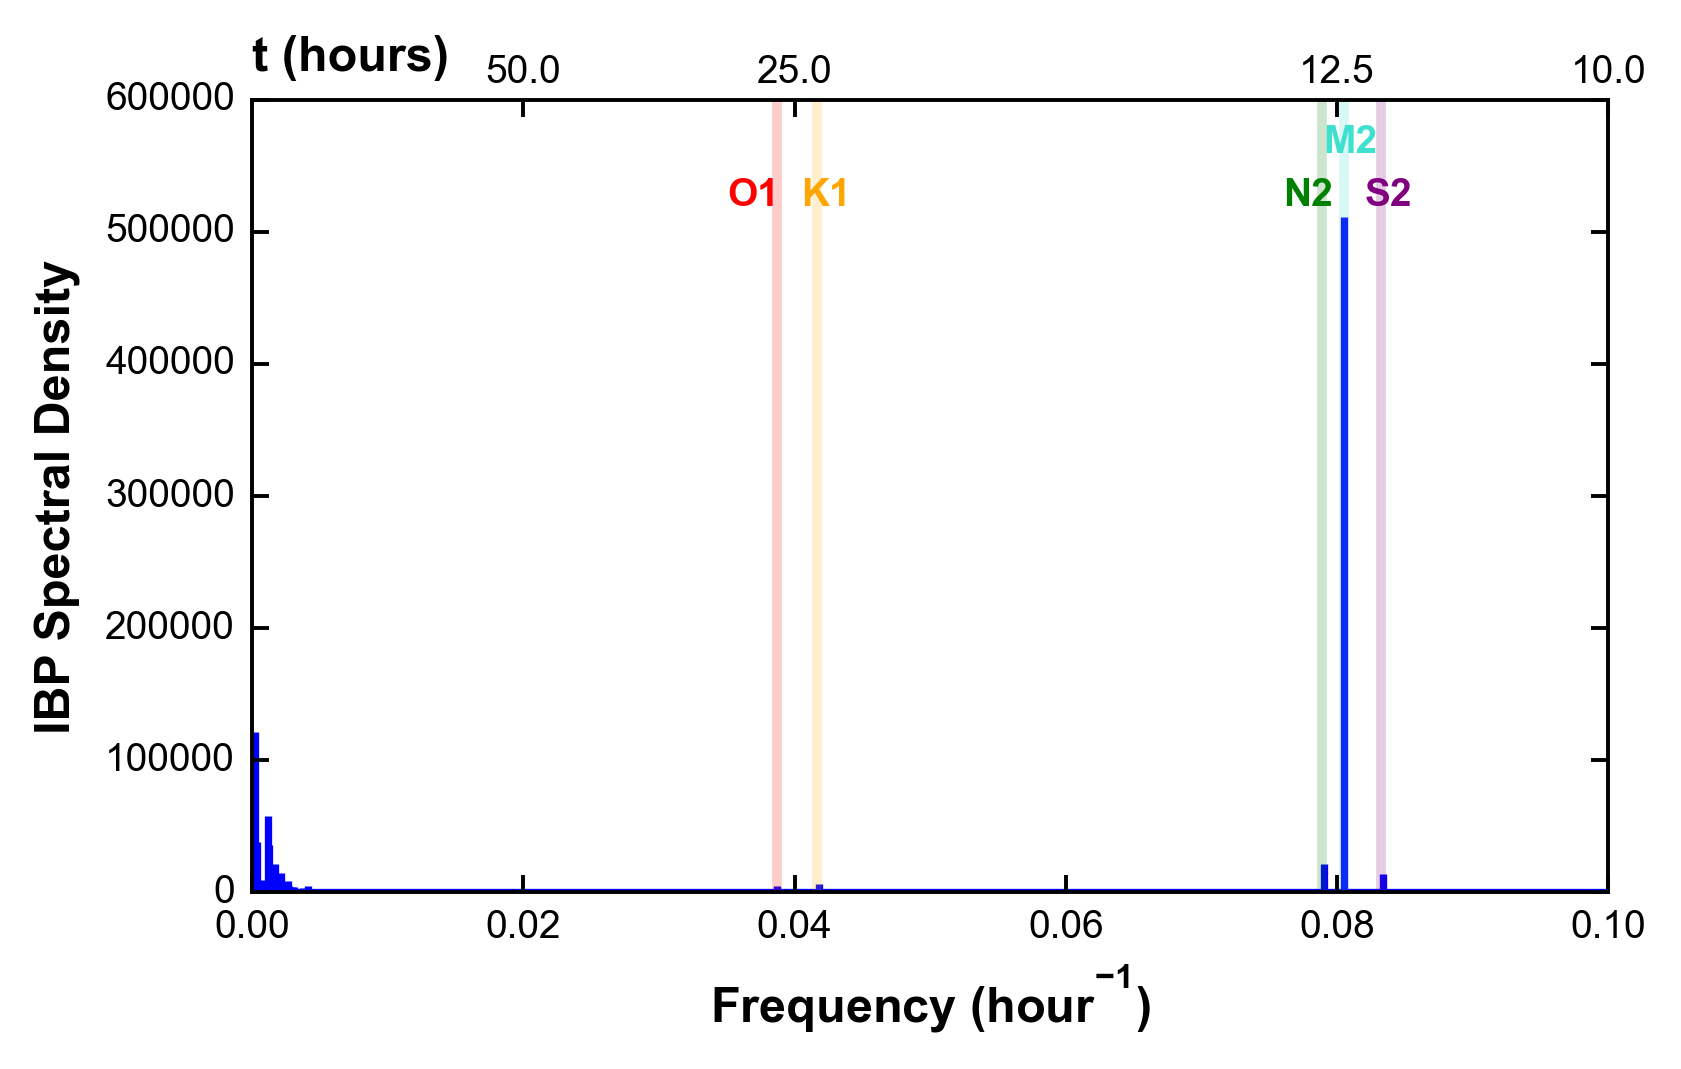

In [10]:
df['IBP'] = df['IBP'].interpolate(method='linear')
nan_true = df['IBP'].isnull().values.any() #check if there are nan values
print('Are there NaN values? ',nan_true)
quantity_nan = df['IBP'].isnull().sum() # how many nan values
print('There are: ', quantity_nan, 'NaN')

short = df.iloc[0:1242,:]
tide = df['IBP']*0.3048
coeff_obs = np.polyfit(df['index'],tide, 1)
print('The linear trend coefficients for observed tide are', coeff_obs[0], 'mm hr-1 and ', coeff_obs[1], 'mm')
print('The linear trend coefficients for observed tide are', coeff_obs[0]*24*365.25, 'mm yr-1 and ', coeff_obs[1], 'mm')
trend_obs = np.polyval(coeff_obs, df['index'])
SL_detrend_obs = np.subtract(tide, trend_obs)

tide_fft_obs = np.fft.fft(SL_detrend_obs)

# Once the FFT has been obtained, square  
# its absolute value in order to get the power spectral density (PSD):
tide_psd_obs = np.abs(tide_fft_obs) ** 2

# The next step is to get the frequencies corresponding to the values of the PSD. 
# The fftfreq() utility function does just that. 
# It takes the length of the PSD vector as input as well as the frequency unit. 
# Here, we choose an annual unit: a frequency of 1 corresponds to 1 year (365.25 days),(1 day = 24 hours). 
# We divide 1/(365.25*24) because the original unit is in hours:
fftfreqs_obs = np.fft.fftfreq(len(tide))

# The fftfreq() function returns positive and negative frequencies. 
# We are only interested in positive frequencies here, as we have a real signal:
i = fftfreqs_obs > 0
print('Fourier Transform')
print(tide_fft_obs[706])
f2_obs = np.log10(tide_psd_obs[i])
print('power spectral density')
print(tide_psd_obs[706])
print('log10 power spectral density')
print(f2_obs[706])
print('frequencies (hour^-1)')
f1_obs=fftfreqs_obs[i]
print(f1_obs[704:710])
print('fft amplitude (m)')
amp_obs = 2.*np.abs(tide_fft_obs[i])/len(tide_fft_obs)
print(amp_obs[706]) 
#print(2.*np.abs(tide_fft[i])/len(tide_fft))
print('periods (hours)')
print(1/f1_obs[706])
print(len(tide_fft_obs[i]))
print(len(fftfreqs_obs[i]))

tide_fft_selected_obs = tide_fft_obs.copy()
tide_fft_selected_obs[np.abs(fftfreqs_obs) >0.0806] = 0
tide_fft_selected_obs[np.abs(fftfreqs_obs) <0.0804] = 0
t_slow_obs = np.real(sp.fftpack.ifft(tide_fft_selected_obs))
np.savetxt('test.csv',t_slow_obs)

vspan_start1 = fftfreqs_obs[fftfreqs_obs==0.08]
vspan_end1 = 1.92
vspan_start2 = 0.099
vspan_end2 = 0.101
xlim_start = 0.000
xlim_end = 0.10

n2 = 0.076
m2 = 0.079
s2 =0.082
k1 = 0.0405
o1 = 0.035
tt1 = 560000
tt =  520000

i = fftfreqs_obs > 0
new_tick_locations = np.array([0.02, 0.04,0.08,0.1])
def tick_function(X):
    V = 1/X
    return ["%.1f" % z for z in V]

plt.figure(figsize=(5,3))

ax = host_subplot(111, axes_class=AA.Axes)
ax.set_xlim([0,xlim_end])
ax.set_ylim([0,600000])
ax.set_xlabel('Frequency ($\mathregular{hour^{-1}}$)')
ax.set_ylabel('IBP Spectral Density')
ax.set_title('t (hours)', loc='left')
ax2 = ax.twin() # ax2 is responsible for "top" axis and "right" axis
ax2.axis["top"].major_ticklabels.set_visible(True)
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tick_function(new_tick_locations))
plt.stem(fftfreqs_obs[i], tide_psd_obs[i], 'b', \
         markerfmt=" ", basefmt="-b")
ax.axvline(x = fftfreqs_obs[366],linewidth=2,linestyle= '-', color= 'orange', alpha=0.2)
ax.axvline(x = fftfreqs_obs[693],linewidth=2,linestyle= '-', color= 'green', alpha=0.2)
ax.axvline(x = fftfreqs_obs[707],linewidth=2,linestyle= '-', color= 'turquoise', alpha=0.2)
ax.axvline(x = fftfreqs_obs[731],linewidth=2,linestyle= '-', color= 'purple', alpha=0.2)
ax.axvline(x = fftfreqs_obs[340],linewidth=2,linestyle= '-', color= 'red', alpha=0.2)
ax.text(n2, tt, 'N2',color='green', size=8, weight='heavy')
ax.text(m2, tt1, 'M2',color='turquoise', size=8, weight='heavy')
ax.text(s2,tt, 'S2',color='purple', size=8, weight='heavy')
ax.text(k1, tt, 'K1',color='orange', size=8, weight='heavy')
ax.text(o1, tt, 'O1',color='red', size=8, weight='heavy')

Are there NaN values?  False
There are:  0 NaN
The linear trend coefficients for observed tide are -2.4786581880329984e-05 mm hr-1 and  0.07855144672555607 mm
The linear trend coefficients for observed tide are -0.21727917676297262 mm yr-1 and  0.07855144672555607 mm
Fourier Transform
(-7.107436965080364+29.466365110573243j)
power spectral density
918.7823330421988
log10 power spectral density
5.660099249777317
frequencies (hour^-1)
[0.08027784 0.08039171 0.08050558 0.08061945 0.08073332 0.08084719]
fft amplitude (m)
0.15398775513198965
periods (hours)
12.421499292786422
4390
4390


Text(0.035, 520000, 'O1')

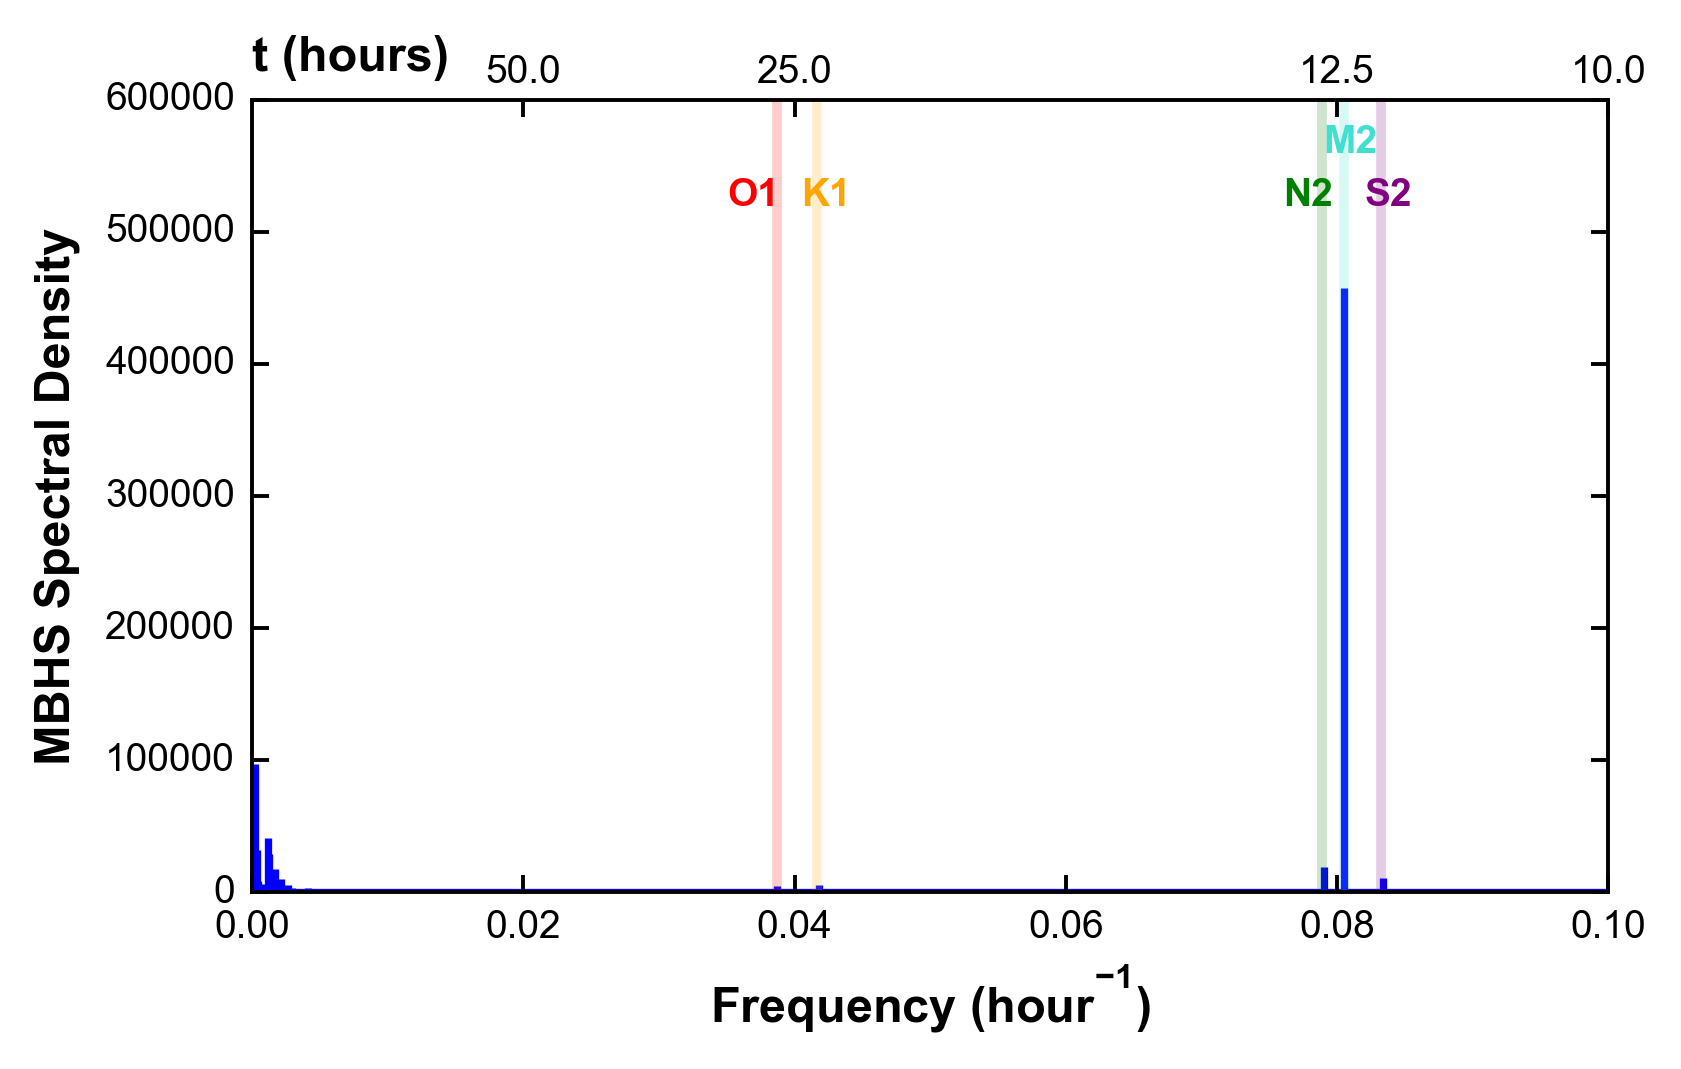

In [11]:
df['MBHS'] = df['MBHS'].interpolate(method='linear')
nan_true = df['MBHS'].isnull().values.any() #check if there are nan values
print('Are there NaN values? ',nan_true)
quantity_nan = df['MBHS'].isnull().sum() # how many nan values
print('There are: ', quantity_nan, 'NaN')

short = df.iloc[0:1242,:]
tide = df['MBHS']*0.3048
coeff_obs = np.polyfit(df['index'],tide, 1)
print('The linear trend coefficients for observed tide are', coeff_obs[0], 'mm hr-1 and ', coeff_obs[1], 'mm')
print('The linear trend coefficients for observed tide are', coeff_obs[0]*24*365.25, 'mm yr-1 and ', coeff_obs[1], 'mm')
trend_obs = np.polyval(coeff_obs, df['index'])
SL_detrend_obs = np.subtract(tide, trend_obs)

tide_fft_obs = np.fft.fft(SL_detrend_obs)

# Once the FFT has been obtained, square  
# its absolute value in order to get the power spectral density (PSD):
tide_psd_obs = np.abs(tide_fft_obs) ** 2

# The next step is to get the frequencies corresponding to the values of the PSD. 
# The fftfreq() utility function does just that. 
# It takes the length of the PSD vector as input as well as the frequency unit. 
# Here, we choose an annual unit: a frequency of 1 corresponds to 1 year (365.25 days),(1 day = 24 hours). 
# We divide 1/(365.25*24) because the original unit is in hours:
fftfreqs_obs = np.fft.fftfreq(len(tide))

# The fftfreq() function returns positive and negative frequencies. 
# We are only interested in positive frequencies here, as we have a real signal:
i = fftfreqs_obs > 0
print('Fourier Transform')
print(tide_fft_obs[706])
f2_obs = np.log10(tide_psd_obs[i])
print('power spectral density')
print(tide_psd_obs[706])
print('log10 power spectral density')
print(f2_obs[706])
print('frequencies (hour^-1)')
f1_obs=fftfreqs_obs[i]
print(f1_obs[704:710])
print('fft amplitude (m)')
amp_obs = 2.*np.abs(tide_fft_obs[i])/len(tide_fft_obs)
print(amp_obs[706]) 
#print(2.*np.abs(tide_fft[i])/len(tide_fft))
print('periods (hours)')
print(1/f1_obs[706])
print(len(tide_fft_obs[i]))
print(len(fftfreqs_obs[i]))

tide_fft_selected_obs = tide_fft_obs.copy()
tide_fft_selected_obs[np.abs(fftfreqs_obs) >0.0806] = 0
tide_fft_selected_obs[np.abs(fftfreqs_obs) <0.0804] = 0
t_slow_obs = np.real(sp.fftpack.ifft(tide_fft_selected_obs))
np.savetxt('test.csv',t_slow_obs)

vspan_start1 = fftfreqs_obs[fftfreqs_obs==0.08]
vspan_end1 = 1.92
vspan_start2 = 0.099
vspan_end2 = 0.101
xlim_start = 0.000
xlim_end = 0.10

n2 = 0.076
m2 = 0.079
s2 =0.082
k1 = 0.0405
o1 = 0.035
tt1 = 560000
tt =  520000

i = fftfreqs_obs > 0
new_tick_locations = np.array([0.02, 0.04,0.08,0.1])
def tick_function(X):
    V = 1/X
    return ["%.1f" % z for z in V]

plt.figure(figsize=(5,3))

ax = host_subplot(111, axes_class=AA.Axes)
ax.set_xlim([0,xlim_end])
ax.set_ylim([0,600000])
ax.set_xlabel('Frequency ($\mathregular{hour^{-1}}$)')
ax.set_ylabel('MBHS Spectral Density')
ax.set_title('t (hours)', loc='left')
ax2 = ax.twin() # ax2 is responsible for "top" axis and "right" axis
ax2.axis["top"].major_ticklabels.set_visible(True)
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tick_function(new_tick_locations))
plt.stem(fftfreqs_obs[i], tide_psd_obs[i], 'b', \
         markerfmt=" ", basefmt="-b")
ax.axvline(x = fftfreqs_obs[366],linewidth=2,linestyle= '-', color= 'orange', alpha=0.2)
ax.axvline(x = fftfreqs_obs[693],linewidth=2,linestyle= '-', color= 'green', alpha=0.2)
ax.axvline(x = fftfreqs_obs[707],linewidth=2,linestyle= '-', color= 'turquoise', alpha=0.2)
ax.axvline(x = fftfreqs_obs[731],linewidth=2,linestyle= '-', color= 'purple', alpha=0.2)
ax.axvline(x = fftfreqs_obs[340],linewidth=2,linestyle= '-', color= 'red', alpha=0.2)
ax.text(n2, tt, 'N2',color='green', size=8, weight='heavy')
ax.text(m2, tt1, 'M2',color='turquoise', size=8, weight='heavy')
ax.text(s2,tt, 'S2',color='purple', size=8, weight='heavy')
ax.text(k1, tt, 'K1',color='orange', size=8, weight='heavy')
ax.text(o1, tt, 'O1',color='red', size=8, weight='heavy')

Are there NaN values?  False
There are:  0 NaN
The linear trend coefficients for observed tide are -2.1645194668592536e-05 mm hr-1 and  0.050412535789538145 mm
The linear trend coefficients for observed tide are -0.18974177646488216 mm yr-1 and  0.050412535789538145 mm
Fourier Transform
(-25.365362516929995+32.0394059804729j)
power spectral density
1669.9251511968396
log10 power spectral density
5.867645695088013
frequencies (hour^-1)
[0.08027784 0.08039171 0.08050558 0.08061945 0.08073332 0.08084719]
fft amplitude (m)
0.1955507159996317
periods (hours)
12.421499292786422
4390
4390


Text(0.035, 780000, 'O1')

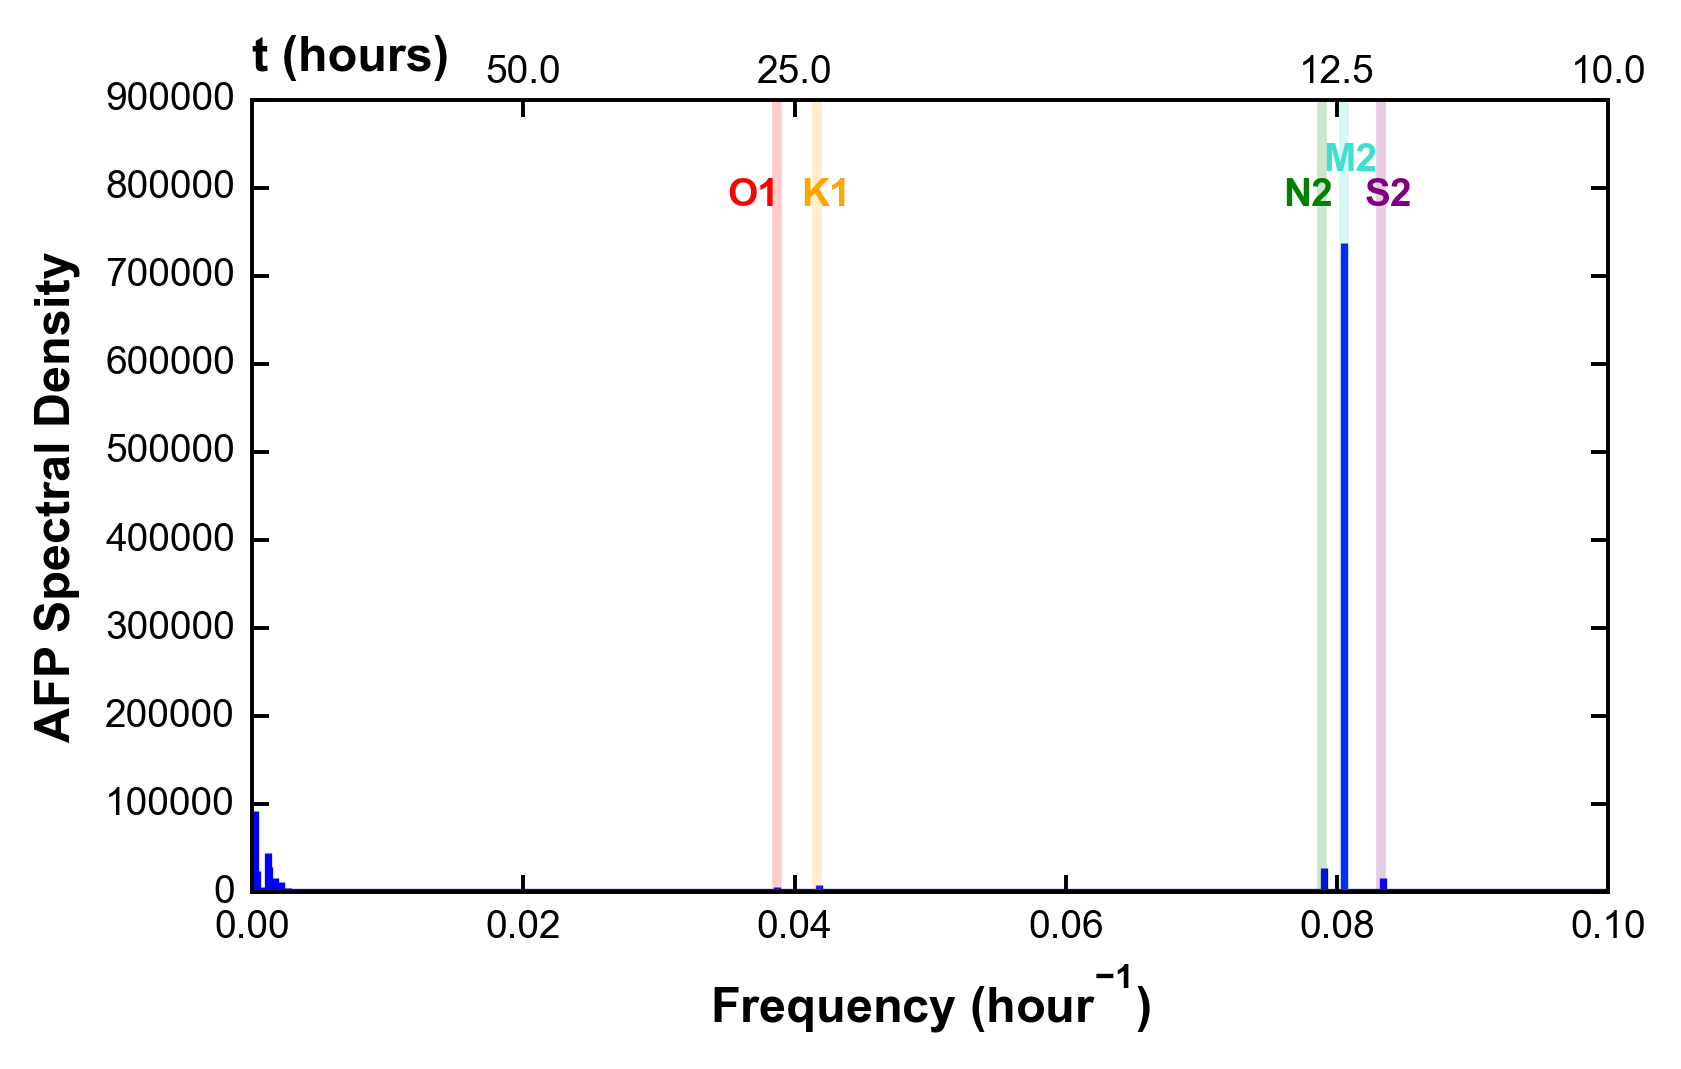

In [12]:
df['AFP'] = df['AFP'].interpolate(method='linear')
nan_true = df['AFP'].isnull().values.any() #check if there are nan values
print('Are there NaN values? ',nan_true)
quantity_nan = df['AFP'].isnull().sum() # how many nan values
print('There are: ', quantity_nan, 'NaN')

short = df.iloc[0:1242,:]
tide = df['AFP']*0.3048
coeff_obs = np.polyfit(df['index'],tide, 1)
print('The linear trend coefficients for observed tide are', coeff_obs[0], 'mm hr-1 and ', coeff_obs[1], 'mm')
print('The linear trend coefficients for observed tide are', coeff_obs[0]*24*365.25, 'mm yr-1 and ', coeff_obs[1], 'mm')
trend_obs = np.polyval(coeff_obs, df['index'])
SL_detrend_obs = np.subtract(tide, trend_obs)

tide_fft_obs = np.fft.fft(SL_detrend_obs)

# Once the FFT has been obtained, square  
# its absolute value in order to get the power spectral density (PSD):
tide_psd_obs = np.abs(tide_fft_obs) ** 2

# The next step is to get the frequencies corresponding to the values of the PSD. 
# The fftfreq() utility function does just that. 
# It takes the length of the PSD vector as input as well as the frequency unit. 
# Here, we choose an annual unit: a frequency of 1 corresponds to 1 year (365.25 days),(1 day = 24 hours). 
# We divide 1/(365.25*24) because the original unit is in hours:
fftfreqs_obs = np.fft.fftfreq(len(tide))

# The fftfreq() function returns positive and negative frequencies. 
# We are only interested in positive frequencies here, as we have a real signal:
i = fftfreqs_obs > 0
print('Fourier Transform')
print(tide_fft_obs[706])
f2_obs = np.log10(tide_psd_obs[i])
print('power spectral density')
print(tide_psd_obs[706])
print('log10 power spectral density')
print(f2_obs[706])
print('frequencies (hour^-1)')
f1_obs=fftfreqs_obs[i]
print(f1_obs[704:710])
print('fft amplitude (m)')
amp_obs = 2.*np.abs(tide_fft_obs[i])/len(tide_fft_obs)
print(amp_obs[706]) 
#print(2.*np.abs(tide_fft[i])/len(tide_fft))
print('periods (hours)')
print(1/f1_obs[706])
print(len(tide_fft_obs[i]))
print(len(fftfreqs_obs[i]))

tide_fft_selected_obs = tide_fft_obs.copy()
tide_fft_selected_obs[np.abs(fftfreqs_obs) >0.0806] = 0
tide_fft_selected_obs[np.abs(fftfreqs_obs) <0.0804] = 0
t_slow_obs = np.real(sp.fftpack.ifft(tide_fft_selected_obs))
np.savetxt('test.csv',t_slow_obs)

vspan_start1 = fftfreqs_obs[fftfreqs_obs==0.08]
vspan_end1 = 1.92
vspan_start2 = 0.099
vspan_end2 = 0.101
xlim_start = 0.000
xlim_end = 0.10

n2 = 0.076
m2 = 0.079
s2 =0.082
k1 = 0.0405
o1 = 0.035
tt1 = 820000
tt =  780000

i = fftfreqs_obs > 0
new_tick_locations = np.array([0.02, 0.04,0.08,0.1])
def tick_function(X):
    V = 1/X
    return ["%.1f" % z for z in V]

plt.figure(figsize=(5,3))

ax = host_subplot(111, axes_class=AA.Axes)
ax.set_xlim([0,xlim_end])
ax.set_ylim([0,900000])
ax.set_xlabel('Frequency ($\mathregular{hour^{-1}}$)')
ax.set_ylabel('AFP Spectral Density')
ax.set_title('t (hours)', loc='left')
ax2 = ax.twin() # ax2 is responsible for "top" axis and "right" axis
ax2.axis["top"].major_ticklabels.set_visible(True)
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tick_function(new_tick_locations))
plt.stem(fftfreqs_obs[i], tide_psd_obs[i], 'b', \
         markerfmt=" ", basefmt="-b")
ax.axvline(x = fftfreqs_obs[366],linewidth=2,linestyle= '-', color= 'orange', alpha=0.2)
ax.axvline(x = fftfreqs_obs[693],linewidth=2,linestyle= '-', color= 'green', alpha=0.2)
ax.axvline(x = fftfreqs_obs[707],linewidth=2,linestyle= '-', color= 'turquoise', alpha=0.2)
ax.axvline(x = fftfreqs_obs[731],linewidth=2,linestyle= '-', color= 'purple', alpha=0.2)
ax.axvline(x = fftfreqs_obs[340],linewidth=2,linestyle= '-', color= 'red', alpha=0.2)
ax.text(n2, tt, 'N2',color='green', size=8, weight='heavy')
ax.text(m2, tt1, 'M2',color='turquoise', size=8, weight='heavy')
ax.text(s2,tt, 'S2',color='purple', size=8, weight='heavy')
ax.text(k1, tt, 'K1',color='orange', size=8, weight='heavy')
ax.text(o1, tt, 'O1',color='red', size=8, weight='heavy')

Are there NaN values?  False
There are:  0 NaN
The linear trend coefficients for observed tide are -1.9930375742630742e-05 mm hr-1 and  0.2829658784146876 mm
The linear trend coefficients for observed tide are -0.1747096737599011 mm yr-1 and  0.2829658784146876 mm
Fourier Transform
(-7.156746484012077+15.38085753562589j)
power spectral density
287.78979876763896
log10 power spectral density
5.161415669667649
frequencies (hour^-1)
[0.08027784 0.08039171 0.08050558 0.08061945 0.08073332 0.08084719]
fft amplitude (m)
0.08672501781556391
periods (hours)
12.421499292786422
4390
4390


Text(0.035, 120000, 'O1')

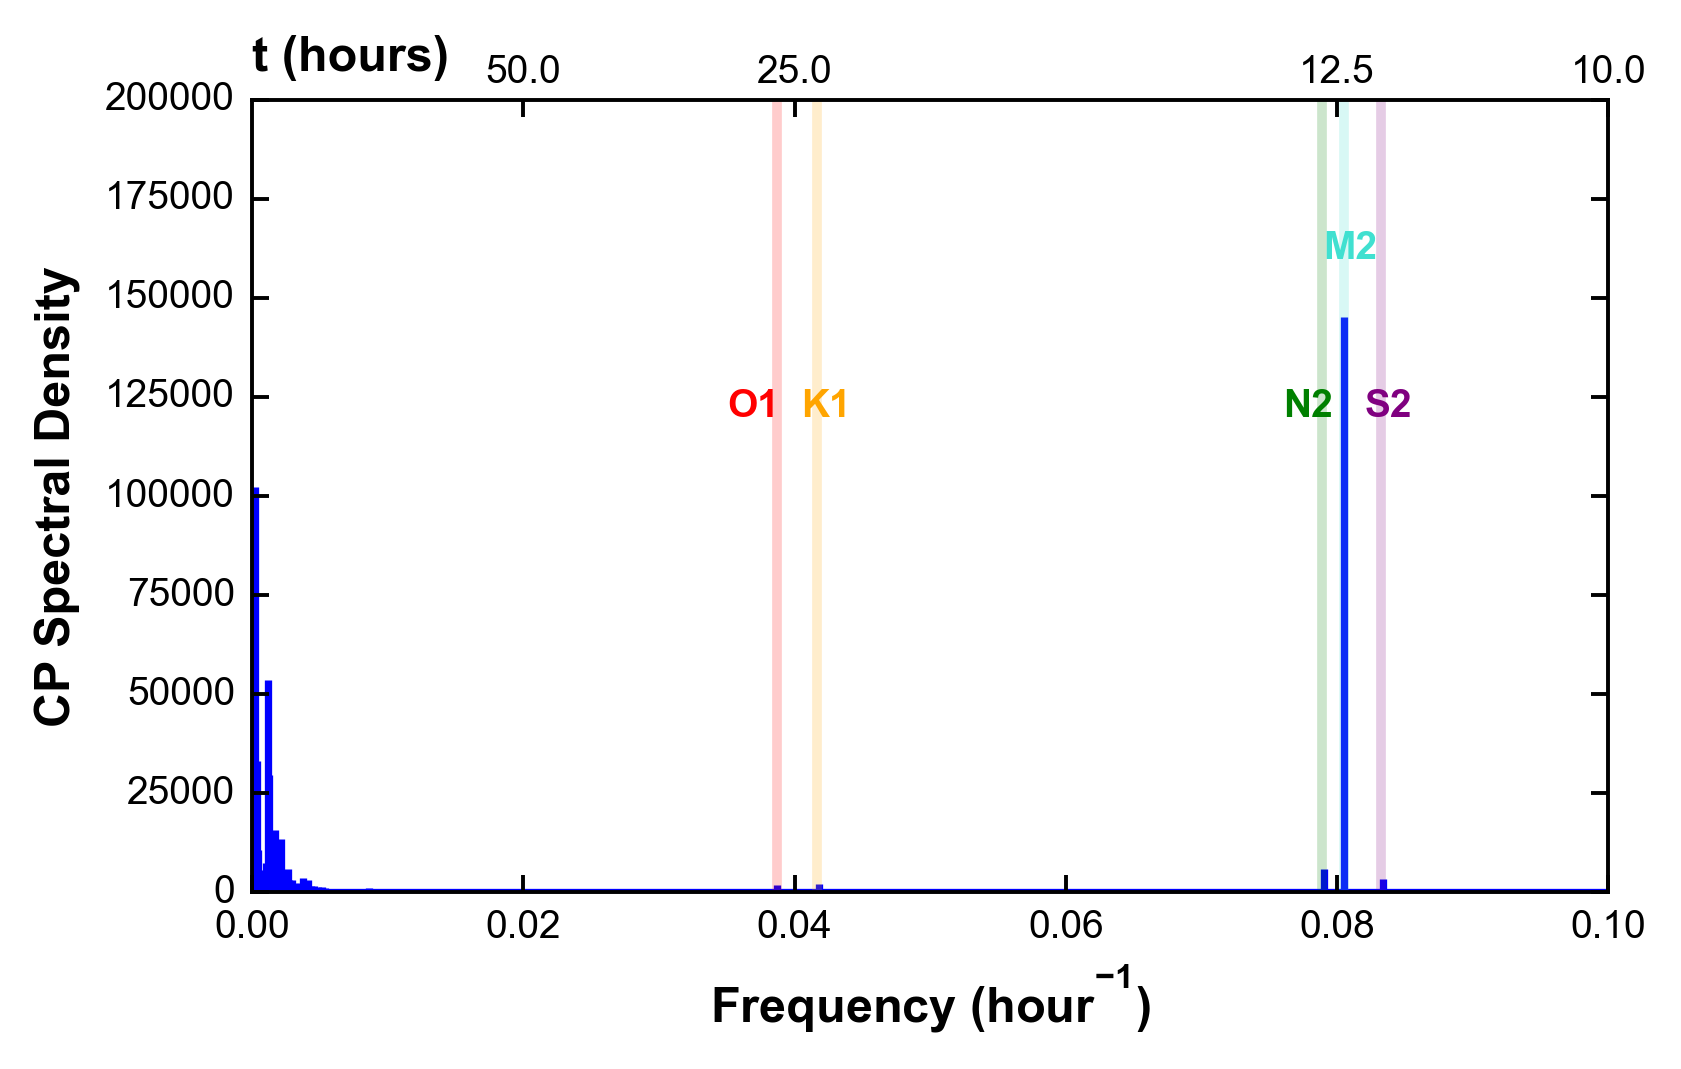

In [13]:
df['CP'] = df['CP'].interpolate(method='linear')
nan_true = df['CP'].isnull().values.any() #check if there are nan values
print('Are there NaN values? ',nan_true)
quantity_nan = df['CP'].isnull().sum() # how many nan values
print('There are: ', quantity_nan, 'NaN')

short = df.iloc[0:1242,:]
tide = df['CP']*0.3048
coeff_obs = np.polyfit(df['index'],tide, 1)
print('The linear trend coefficients for observed tide are', coeff_obs[0], 'mm hr-1 and ', coeff_obs[1], 'mm')
print('The linear trend coefficients for observed tide are', coeff_obs[0]*24*365.25, 'mm yr-1 and ', coeff_obs[1], 'mm')
trend_obs = np.polyval(coeff_obs, df['index'])
SL_detrend_obs = np.subtract(tide, trend_obs)

tide_fft_obs = np.fft.fft(SL_detrend_obs)

# Once the FFT has been obtained, square  
# its absolute value in order to get the power spectral density (PSD):
tide_psd_obs = np.abs(tide_fft_obs) ** 2

# The next step is to get the frequencies corresponding to the values of the PSD. 
# The fftfreq() utility function does just that. 
# It takes the length of the PSD vector as input as well as the frequency unit. 
# Here, we choose an annual unit: a frequency of 1 corresponds to 1 year (365.25 days),(1 day = 24 hours). 
# We divide 1/(365.25*24) because the original unit is in hours:
fftfreqs_obs = np.fft.fftfreq(len(tide))

# The fftfreq() function returns positive and negative frequencies. 
# We are only interested in positive frequencies here, as we have a real signal:
i = fftfreqs_obs > 0
print('Fourier Transform')
print(tide_fft_obs[706])
f2_obs = np.log10(tide_psd_obs[i])
print('power spectral density')
print(tide_psd_obs[706])
print('log10 power spectral density')
print(f2_obs[706])
print('frequencies (hour^-1)')
f1_obs=fftfreqs_obs[i]
print(f1_obs[704:710])
print('fft amplitude (m)')
amp_obs = 2.*np.abs(tide_fft_obs[i])/len(tide_fft_obs)
print(amp_obs[706]) 
#print(2.*np.abs(tide_fft[i])/len(tide_fft))
print('periods (hours)')
print(1/f1_obs[706])
print(len(tide_fft_obs[i]))
print(len(fftfreqs_obs[i]))

tide_fft_selected_obs = tide_fft_obs.copy()
tide_fft_selected_obs[np.abs(fftfreqs_obs) >0.0806] = 0
tide_fft_selected_obs[np.abs(fftfreqs_obs) <0.0804] = 0
t_slow_obs = np.real(sp.fftpack.ifft(tide_fft_selected_obs))
np.savetxt('test.csv',t_slow_obs)

vspan_start1 = fftfreqs_obs[fftfreqs_obs==0.08]
vspan_end1 = 1.92
vspan_start2 = 0.099
vspan_end2 = 0.101
xlim_start = 0.000
xlim_end = 0.10

n2 = 0.076
m2 = 0.079
s2 =0.082
k1 = 0.0405
o1 = 0.035
tt1 = 160000
tt =  120000

i = fftfreqs_obs > 0
new_tick_locations = np.array([0.02, 0.04,0.08,0.1])
def tick_function(X):
    V = 1/X
    return ["%.1f" % z for z in V]

plt.figure(figsize=(5,3))

ax = host_subplot(111, axes_class=AA.Axes)
ax.set_xlim([0,xlim_end])
ax.set_ylim([0,200000])
ax.set_xlabel('Frequency ($\mathregular{hour^{-1}}$)')
ax.set_ylabel('CP Spectral Density')
ax.set_title('t (hours)', loc='left')
ax2 = ax.twin() # ax2 is responsible for "top" axis and "right" axis
ax2.axis["top"].major_ticklabels.set_visible(True)
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tick_function(new_tick_locations))
plt.stem(fftfreqs_obs[i], tide_psd_obs[i], 'b', \
         markerfmt=" ", basefmt="-b")
ax.axvline(x = fftfreqs_obs[366],linewidth=2,linestyle= '-', color= 'orange', alpha=0.2)
ax.axvline(x = fftfreqs_obs[693],linewidth=2,linestyle= '-', color= 'green', alpha=0.2)
ax.axvline(x = fftfreqs_obs[707],linewidth=2,linestyle= '-', color= 'turquoise', alpha=0.2)
ax.axvline(x = fftfreqs_obs[731],linewidth=2,linestyle= '-', color= 'purple', alpha=0.2)
ax.axvline(x = fftfreqs_obs[340],linewidth=2,linestyle= '-', color= 'red', alpha=0.2)
ax.text(n2, tt, 'N2',color='green', size=8, weight='heavy')
ax.text(m2, tt1, 'M2',color='turquoise', size=8, weight='heavy')
ax.text(s2,tt, 'S2',color='purple', size=8, weight='heavy')
ax.text(k1, tt, 'K1',color='orange', size=8, weight='heavy')
ax.text(o1, tt, 'O1',color='red', size=8, weight='heavy')

Are there NaN values?  False
There are:  0 NaN
The linear trend coefficients for observed tide are -2.2482253004355e-05 mm hr-1 and  -0.14615943052258434 mm
The linear trend coefficients for observed tide are -0.1970794298361759 mm yr-1 and  -0.14615943052258434 mm
Fourier Transform
(-10.247974961479173+45.231368123188766j)
power spectral density
2150.897653106521
log10 power spectral density
5.8646546814940725
frequencies (hour^-1)
[0.08027784 0.08039171 0.08050558 0.08061945 0.08073332 0.08084719]
fft amplitude (m)
0.19487848900024737
periods (hours)
12.421499292786422
4390
4390


Text(0.035, 780000, 'O1')

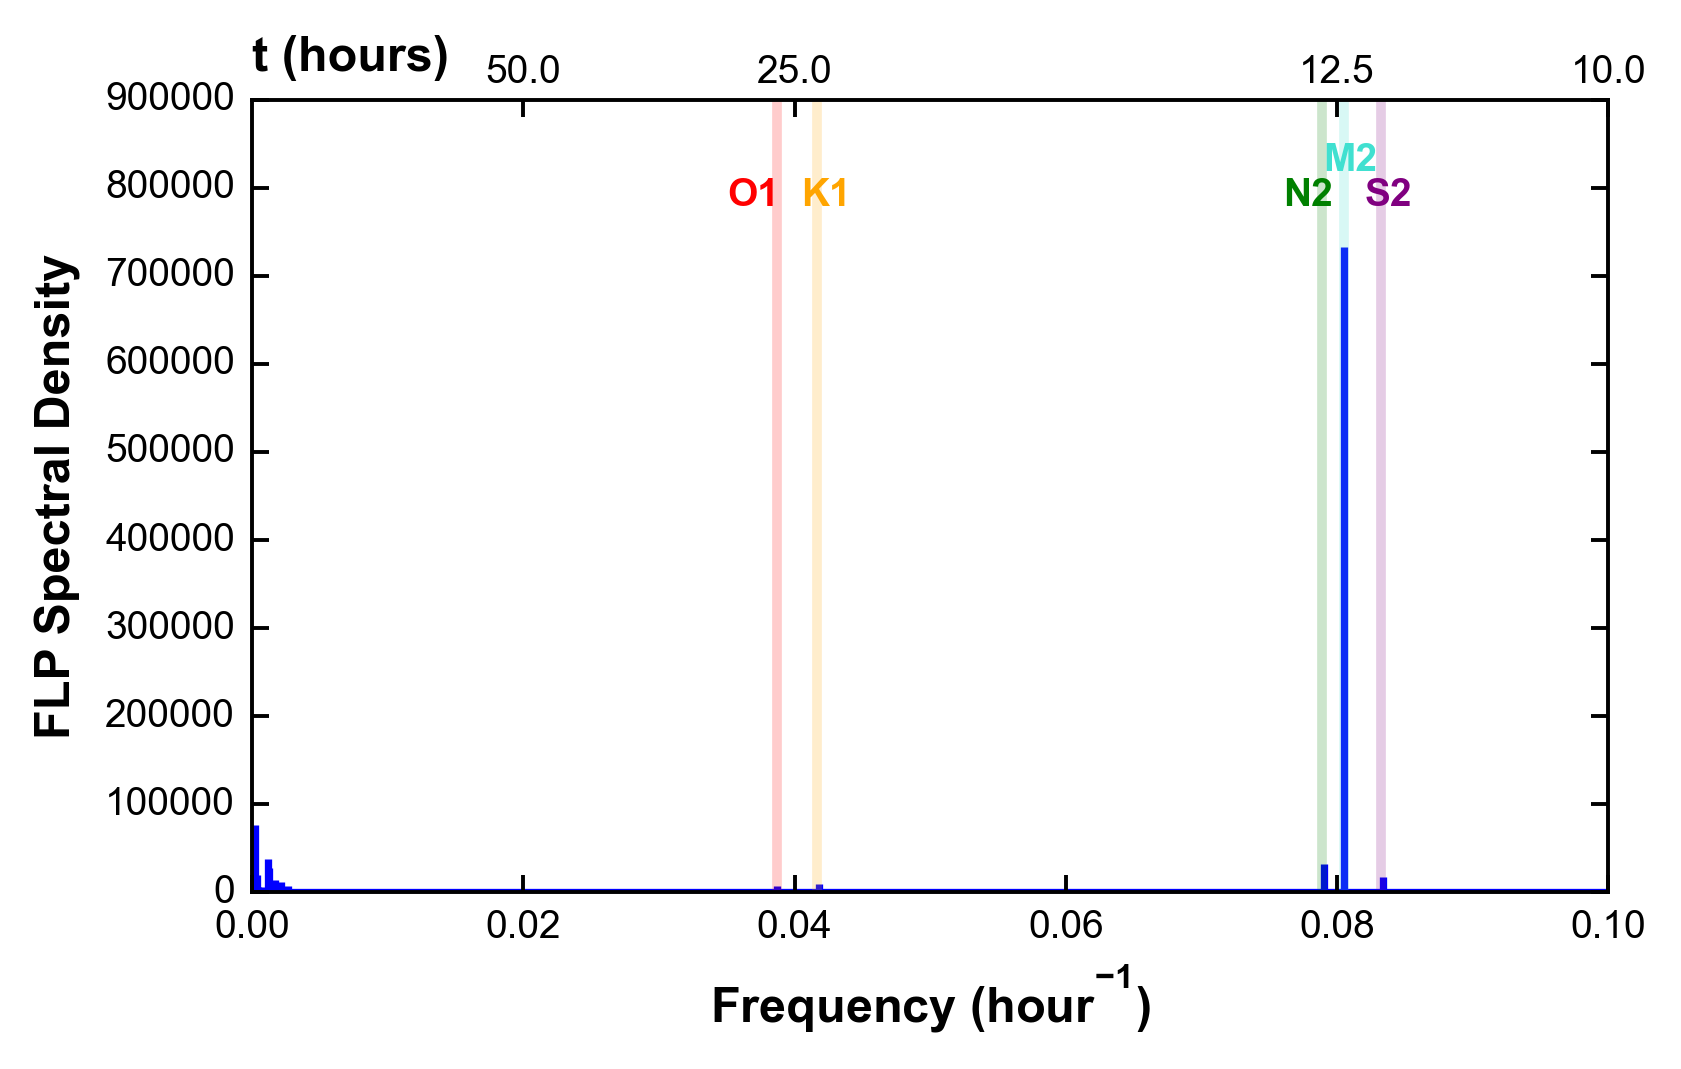

In [14]:
df['FLP'] = df['FLP'].interpolate(method='linear')
nan_true = df['FLP'].isnull().values.any() #check if there are nan values
print('Are there NaN values? ',nan_true)
quantity_nan = df['FLP'].isnull().sum() # how many nan values
print('There are: ', quantity_nan, 'NaN')

short = df.iloc[0:1242,:]
tide = df['FLP']*0.3048
coeff_obs = np.polyfit(df['index'],tide, 1)
print('The linear trend coefficients for observed tide are', coeff_obs[0], 'mm hr-1 and ', coeff_obs[1], 'mm')
print('The linear trend coefficients for observed tide are', coeff_obs[0]*24*365.25, 'mm yr-1 and ', coeff_obs[1], 'mm')
trend_obs = np.polyval(coeff_obs, df['index'])
SL_detrend_obs = np.subtract(tide, trend_obs)

tide_fft_obs = np.fft.fft(SL_detrend_obs)

# Once the FFT has been obtained, square  
# its absolute value in order to get the power spectral density (PSD):
tide_psd_obs = np.abs(tide_fft_obs) ** 2

# The next step is to get the frequencies corresponding to the values of the PSD. 
# The fftfreq() utility function does just that. 
# It takes the length of the PSD vector as input as well as the frequency unit. 
# Here, we choose an annual unit: a frequency of 1 corresponds to 1 year (365.25 days),(1 day = 24 hours). 
# We divide 1/(365.25*24) because the original unit is in hours:
fftfreqs_obs = np.fft.fftfreq(len(tide))

# The fftfreq() function returns positive and negative frequencies. 
# We are only interested in positive frequencies here, as we have a real signal:
i = fftfreqs_obs > 0
print('Fourier Transform')
print(tide_fft_obs[706])
f2_obs = np.log10(tide_psd_obs[i])
print('power spectral density')
print(tide_psd_obs[706])
print('log10 power spectral density')
print(f2_obs[706])
print('frequencies (hour^-1)')
f1_obs=fftfreqs_obs[i]
print(f1_obs[704:710])
print('fft amplitude (m)')
amp_obs = 2.*np.abs(tide_fft_obs[i])/len(tide_fft_obs)
print(amp_obs[706]) 
#print(2.*np.abs(tide_fft[i])/len(tide_fft))
print('periods (hours)')
print(1/f1_obs[706])
print(len(tide_fft_obs[i]))
print(len(fftfreqs_obs[i]))

tide_fft_selected_obs = tide_fft_obs.copy()
tide_fft_selected_obs[np.abs(fftfreqs_obs) >0.0806] = 0
tide_fft_selected_obs[np.abs(fftfreqs_obs) <0.0804] = 0
t_slow_obs = np.real(sp.fftpack.ifft(tide_fft_selected_obs))
np.savetxt('test.csv',t_slow_obs)

vspan_start1 = fftfreqs_obs[fftfreqs_obs==0.08]
vspan_end1 = 1.92
vspan_start2 = 0.099
vspan_end2 = 0.101
xlim_start = 0.000
xlim_end = 0.10

n2 = 0.076
m2 = 0.079
s2 =0.082
k1 = 0.0405
o1 = 0.035
tt1 = 820000
tt =  780000

i = fftfreqs_obs > 0
new_tick_locations = np.array([0.02, 0.04,0.08,0.1])
def tick_function(X):
    V = 1/X
    return ["%.1f" % z for z in V]

plt.figure(figsize=(5,3))

ax = host_subplot(111, axes_class=AA.Axes)
ax.set_xlim([0,xlim_end])
ax.set_ylim([0,900000])
ax.set_xlabel('Frequency ($\mathregular{hour^{-1}}$)')
ax.set_ylabel('FLP Spectral Density')
ax.set_title('t (hours)', loc='left')
ax2 = ax.twin() # ax2 is responsible for "top" axis and "right" axis
ax2.axis["top"].major_ticklabels.set_visible(True)
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tick_function(new_tick_locations))
plt.stem(fftfreqs_obs[i], tide_psd_obs[i], 'b', \
         markerfmt=" ", basefmt="-b")
ax.axvline(x = fftfreqs_obs[366],linewidth=2,linestyle= '-', color= 'orange', alpha=0.2)
ax.axvline(x = fftfreqs_obs[693],linewidth=2,linestyle= '-', color= 'green', alpha=0.2)
ax.axvline(x = fftfreqs_obs[707],linewidth=2,linestyle= '-', color= 'turquoise', alpha=0.2)
ax.axvline(x = fftfreqs_obs[731],linewidth=2,linestyle= '-', color= 'purple', alpha=0.2)
ax.axvline(x = fftfreqs_obs[340],linewidth=2,linestyle= '-', color= 'red', alpha=0.2)
ax.text(n2, tt, 'N2',color='green', size=8, weight='heavy')
ax.text(m2, tt1, 'M2',color='turquoise', size=8, weight='heavy')
ax.text(s2,tt, 'S2',color='purple', size=8, weight='heavy')
ax.text(k1, tt, 'K1',color='orange', size=8, weight='heavy')
ax.text(o1, tt, 'O1',color='red', size=8, weight='heavy')

Are there NaN values?  False
There are:  0 NaN
The linear trend coefficients for observed tide are -1.0171747869030798e-05 mm hr-1 and  0.12014089690212544 mm
The linear trend coefficients for observed tide are -0.08916554181992398 mm yr-1 and  0.12014089690212544 mm
Fourier Transform
(-22.181348754730106+56.30707664820093j)
power spectral density
3662.4991132453415
log10 power spectral density
6.191630702688699
frequencies (hour^-1)
[0.08027784 0.08039171 0.08050558 0.08061945 0.08073332 0.08084719]
fft amplitude (m)
0.28395656521700463
periods (hours)
12.421499292786422
4390
4390


Text(0.035, 1650000, 'O1')

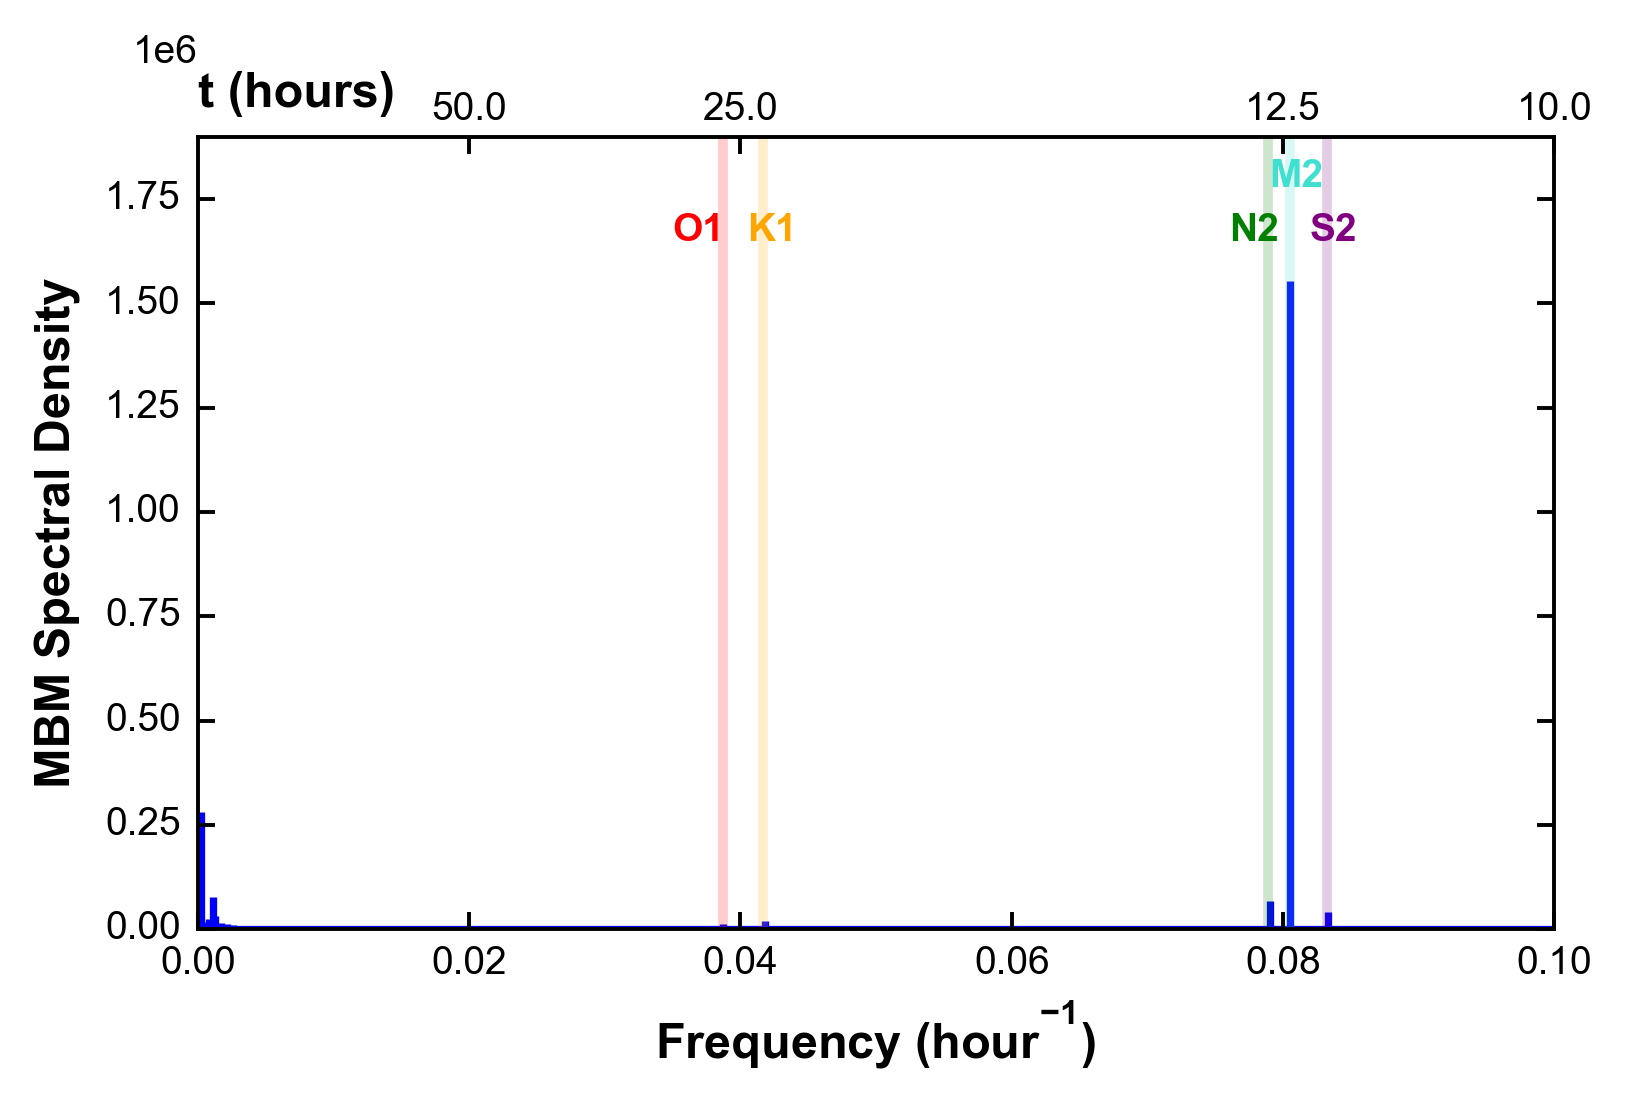

In [15]:
df['MBM'] = df['MBM'].interpolate(method='linear')
nan_true = df['MBM'].isnull().values.any() #check if there are nan values
print('Are there NaN values? ',nan_true)
quantity_nan = df['MBM'].isnull().sum() # how many nan values
print('There are: ', quantity_nan, 'NaN')

short = df.iloc[0:1242,:]
tide = df['MBM']*0.3048
coeff_obs = np.polyfit(df['index'],tide, 1)
print('The linear trend coefficients for observed tide are', coeff_obs[0], 'mm hr-1 and ', coeff_obs[1], 'mm')
print('The linear trend coefficients for observed tide are', coeff_obs[0]*24*365.25, 'mm yr-1 and ', coeff_obs[1], 'mm')
trend_obs = np.polyval(coeff_obs, df['index'])
SL_detrend_obs = np.subtract(tide, trend_obs)

tide_fft_obs = np.fft.fft(SL_detrend_obs)

# Once the FFT has been obtained, square  
# its absolute value in order to get the power spectral density (PSD):
tide_psd_obs = np.abs(tide_fft_obs) ** 2

# The next step is to get the frequencies corresponding to the values of the PSD. 
# The fftfreq() utility function does just that. 
# It takes the length of the PSD vector as input as well as the frequency unit. 
# Here, we choose an annual unit: a frequency of 1 corresponds to 1 year (365.25 days),(1 day = 24 hours). 
# We divide 1/(365.25*24) because the original unit is in hours:
fftfreqs_obs = np.fft.fftfreq(len(tide))

# The fftfreq() function returns positive and negative frequencies. 
# We are only interested in positive frequencies here, as we have a real signal:
i = fftfreqs_obs > 0
print('Fourier Transform')
print(tide_fft_obs[706])
f2_obs = np.log10(tide_psd_obs[i])
print('power spectral density')
print(tide_psd_obs[706])
print('log10 power spectral density')
print(f2_obs[706])
print('frequencies (hour^-1)')
f1_obs=fftfreqs_obs[i]
print(f1_obs[704:710])
print('fft amplitude (m)')
amp_obs = 2.*np.abs(tide_fft_obs[i])/len(tide_fft_obs)
print(amp_obs[706]) 
#print(2.*np.abs(tide_fft[i])/len(tide_fft))
print('periods (hours)')
print(1/f1_obs[706])
print(len(tide_fft_obs[i]))
print(len(fftfreqs_obs[i]))

tide_fft_selected_obs = tide_fft_obs.copy()
tide_fft_selected_obs[np.abs(fftfreqs_obs) >0.0806] = 0
tide_fft_selected_obs[np.abs(fftfreqs_obs) <0.0804] = 0
t_slow_obs = np.real(sp.fftpack.ifft(tide_fft_selected_obs))
np.savetxt('test.csv',t_slow_obs)

vspan_start1 = fftfreqs_obs[fftfreqs_obs==0.08]
vspan_end1 = 1.92
vspan_start2 = 0.099
vspan_end2 = 0.101
xlim_start = 0.000
xlim_end = 0.10

n2 = 0.076
m2 = 0.079
s2 =0.082
k1 = 0.0405
o1 = 0.035
tt1 = 1780000
tt = 1650000

i = fftfreqs_obs > 0
new_tick_locations = np.array([0.02, 0.04,0.08,0.1])
def tick_function(X):
    V = 1/X
    return ["%.1f" % z for z in V]

plt.figure(figsize=(5,3))

ax = host_subplot(111, axes_class=AA.Axes)
ax.set_xlim([0,xlim_end])
ax.set_ylim([0,1900000])
ax.set_xlabel('Frequency ($\mathregular{hour^{-1}}$)')
ax.set_ylabel('MBM Spectral Density')
ax.set_title('t (hours)', loc='left')
ax2 = ax.twin() # ax2 is responsible for "top" axis and "right" axis
ax2.axis["top"].major_ticklabels.set_visible(True)
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tick_function(new_tick_locations))
plt.stem(fftfreqs_obs[i], tide_psd_obs[i], 'b', \
         markerfmt=" ", basefmt="-b")
ax.axvline(x = fftfreqs_obs[366],linewidth=2,linestyle= '-', color= 'orange', alpha=0.2)
ax.axvline(x = fftfreqs_obs[693],linewidth=2,linestyle= '-', color= 'green', alpha=0.2)
ax.axvline(x = fftfreqs_obs[707],linewidth=2,linestyle= '-', color= 'turquoise', alpha=0.2)
ax.axvline(x = fftfreqs_obs[731],linewidth=2,linestyle= '-', color= 'purple', alpha=0.2)
ax.axvline(x = fftfreqs_obs[340],linewidth=2,linestyle= '-', color= 'red', alpha=0.2)
ax.text(n2, tt, 'N2',color='green', size=8, weight='heavy')
ax.text(m2, tt1, 'M2',color='turquoise', size=8, weight='heavy')
ax.text(s2,tt, 'S2',color='purple', size=8, weight='heavy')
ax.text(k1, tt, 'K1',color='orange', size=8, weight='heavy')
ax.text(o1, tt, 'O1',color='red', size=8, weight='heavy')

Are there NaN values?  False
There are:  0 NaN
The linear trend coefficients for observed tide are -1.6554853323058706e-05 mm hr-1 and  -0.22043771280464136 mm
The linear trend coefficients for observed tide are -0.14511984422993263 mm yr-1 and  -0.22043771280464136 mm
Fourier Transform
(-73.88637550474303+17.08209898273426j)
power spectral density
5750.994590883822
log10 power spectral density
6.427455456593698
frequencies (hour^-1)
[0.08039171 0.08050558 0.08061945 0.08073332 0.08084719]
fft amplitude (m)
0.3725326066197537
periods (hours)
12.421499292786422
4390
4390


Text(0.035, 1650000, 'O1')

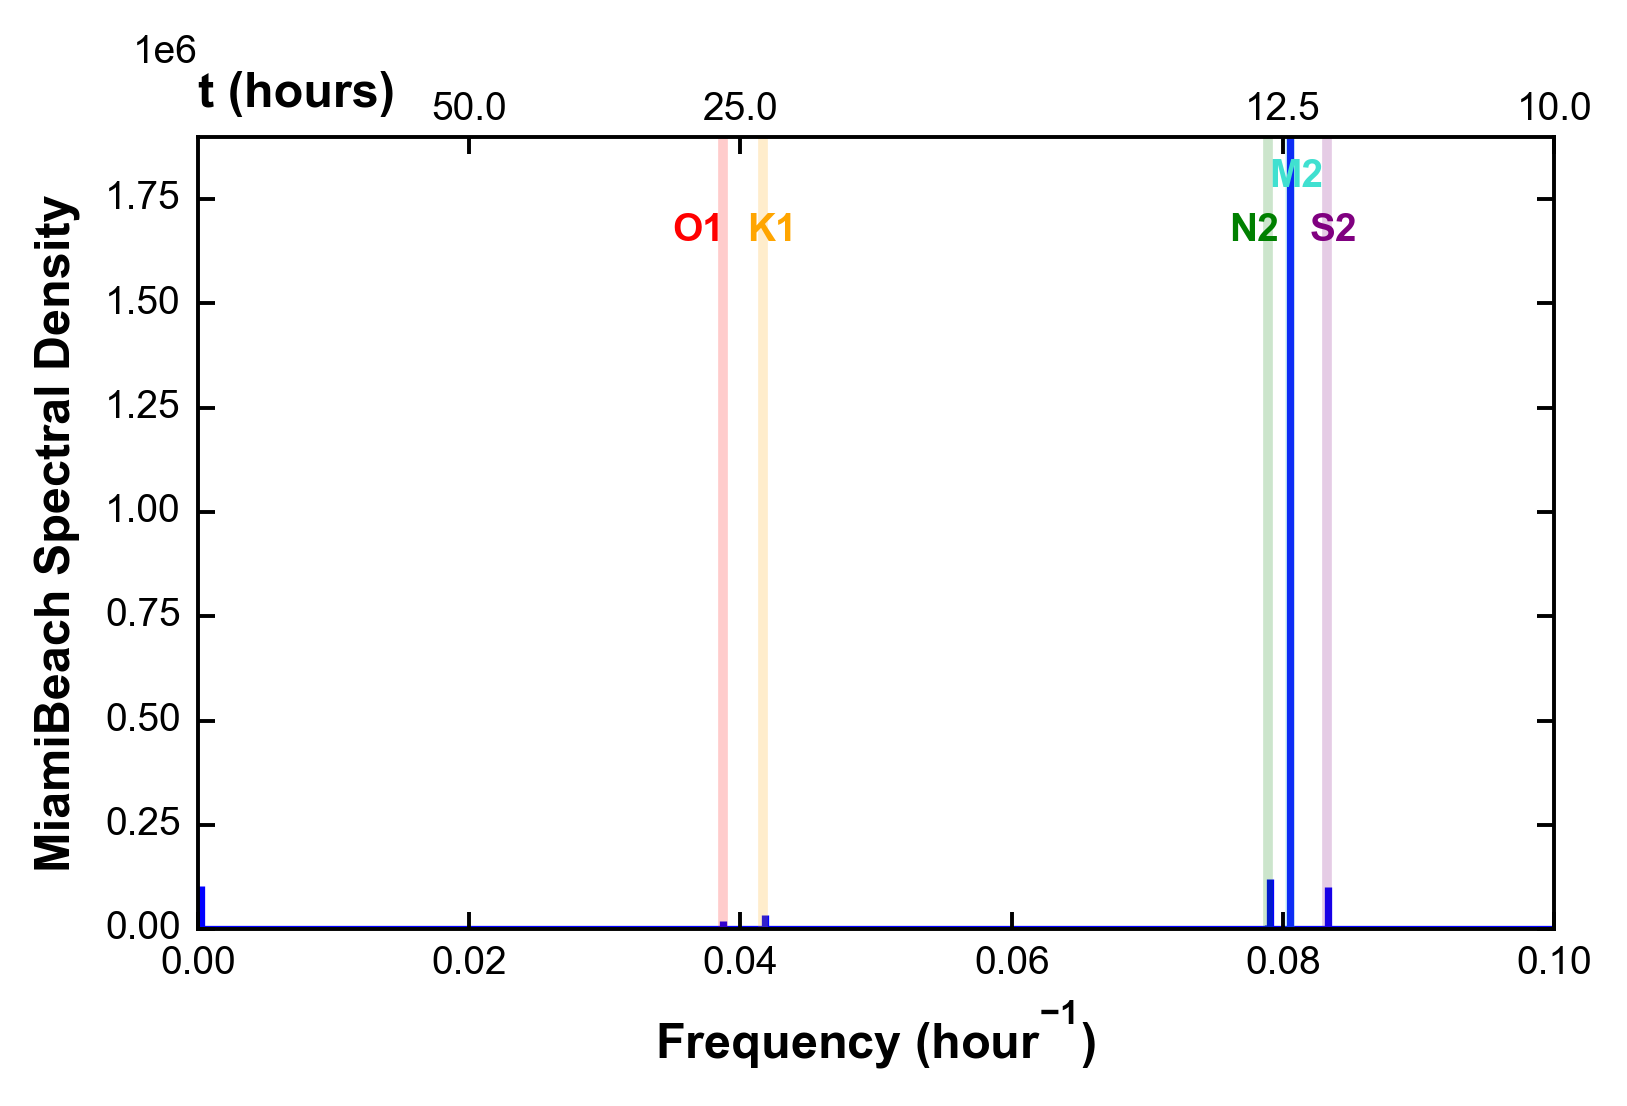

In [16]:
df['MiamiBeach'] = df['MiamiBeach'].interpolate(method='linear')
nan_true = df['MiamiBeach'].isnull().values.any() #check if there are nan values
print('Are there NaN values? ',nan_true)
quantity_nan = df['MiamiBeach'].isnull().sum() # how many nan values
print('There are: ', quantity_nan, 'NaN')

#Find linear trend
short = df.iloc[0:1242,:]
tide = df['MiamiBeach']
coeff_obs = np.polyfit(df['index'],tide, 1)
print('The linear trend coefficients for observed tide are', coeff_obs[0], 'mm hr-1 and ', coeff_obs[1], 'mm')
print('The linear trend coefficients for observed tide are', coeff_obs[0]*24*365.25, 'mm yr-1 and ', coeff_obs[1], 'mm')
trend_obs = np.polyval(coeff_obs, df['index'])
SL_detrend_obs = np.subtract(tide, trend_obs)

# We now compute the Fourier transform and the spectral density of the signal. 
# The first step is to compute the FFT of the signal using the fft() function:
tide_fft_obs = np.fft.fft(SL_detrend_obs)

# Once the FFT has been obtained, square  
# its absolute value in order to get the power spectral density (PSD):
tide_psd_obs = np.abs(tide_fft_obs) ** 2

# The next step is to get the frequencies corresponding to the values of the PSD. 
# The fftfreq() utility function does just that. 
# It takes the length of the PSD vector as input as well as the frequency unit. 
# Here, we choose an annual unit: a frequency of 1 corresponds to 1 year (365.25 days),(1 day = 24 hours). 
# We divide 1/(365.25*24) because the original unit is in hours:
fftfreqs_obs = np.fft.fftfreq(len(tide))

# The fftfreq() function returns positive and negative frequencies. 
# We are only interested in positive frequencies here, as we have a real signal:
i = fftfreqs_obs > 0
print('Fourier Transform')
print(tide_fft_obs[706])
f2_obs = np.log10(tide_psd_obs[i])
print('power spectral density')
print(tide_psd_obs[706])
print('log10 power spectral density')
print(f2_obs[706])
print('frequencies (hour^-1)')
f1_obs=fftfreqs_obs[i]
print(f1_obs[705:710])
print('fft amplitude (m)')
amp_obs = 2.*np.abs(tide_fft_obs[i])/len(tide_fft_obs)
print(amp_obs[706]) 
#print(2.*np.abs(tide_fft[i])/len(tide_fft))
print('periods (hours)')
print(1/f1_obs[706])
print(len(tide_fft_obs[i]))
print(len(fftfreqs_obs[i]))

tide_fft_selected_obs = tide_fft_obs.copy()
tide_fft_selected_obs[np.abs(fftfreqs_obs) >0.0806] = 0
tide_fft_selected_obs[np.abs(fftfreqs_obs) <0.0804] = 0
t_slow_obs = np.real(sp.fftpack.ifft(tide_fft_selected_obs))
np.savetxt('test.csv',t_slow_obs)

vspan_start1 = fftfreqs_obs[fftfreqs_obs==0.08]
vspan_end1 = 1.92
vspan_start2 = 0.099
vspan_end2 = 0.101
xlim_start = 0.000
xlim_end = 0.10

n2 = 0.076
m2 = 0.079
s2 =0.082
k1 = 0.0405
o1 = 0.035
tt1 = 1780000
tt = 1650000

i = fftfreqs_obs > 0
new_tick_locations = np.array([0.02, 0.04,0.08,0.1])
def tick_function(X):
    V = 1/X
    return ["%.1f" % z for z in V]

plt.figure(figsize=(5,3))

ax = host_subplot(111, axes_class=AA.Axes)
ax.set_xlim([0,xlim_end])
ax.set_ylim([0,1900000])
ax.set_xlabel('Frequency ($\mathregular{hour^{-1}}$)')
ax.set_ylabel('MiamiBeach Spectral Density')
ax.set_title('t (hours)', loc='left')
ax2 = ax.twin() # ax2 is responsible for "top" axis and "right" axis
ax2.axis["top"].major_ticklabels.set_visible(True)
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tick_function(new_tick_locations))
plt.stem(fftfreqs_obs[i], tide_psd_obs[i], 'b', \
         markerfmt=" ", basefmt="-b")
ax.axvline(x = fftfreqs_obs[366],linewidth=2,linestyle= '-', color= 'orange', alpha=0.2)
ax.axvline(x = fftfreqs_obs[693],linewidth=2,linestyle= '-', color= 'green', alpha=0.2)
ax.axvline(x = fftfreqs_obs[707],linewidth=2,linestyle= '-', color= 'turquoise', alpha=0.2)
ax.axvline(x = fftfreqs_obs[731],linewidth=2,linestyle= '-', color= 'purple', alpha=0.2)
ax.axvline(x = fftfreqs_obs[340],linewidth=2,linestyle= '-', color= 'red', alpha=0.2)
ax.text(n2, tt, 'N2',color='green', size=8, weight='heavy')
ax.text(m2, tt1, 'M2',color='turquoise', size=8, weight='heavy')
ax.text(s2,tt, 'S2',color='purple', size=8, weight='heavy')
ax.text(k1, tt, 'K1',color='orange', size=8, weight='heavy')
ax.text(o1, tt, 'O1',color='red', size=8, weight='heavy')

Are there NaN values?  False
There are:  0 NaN
The linear trend coefficients for observed tide are -2.3203603737251362e-05 mm hr-1 and  0.0485126696540225 mm
The linear trend coefficients for observed tide are -0.20340279036074543 mm yr-1 and  0.0485126696540225 mm
Fourier Transform
(11.67976356907092+17.89484665981271j)
power spectral density
456.64241400760636
log10 power spectral density
6.230249513767414
frequencies (hour^-1)
[0.08039171 0.08050558 0.08061945 0.08073332 0.08084719]
fft amplitude (m)
0.2968665871711431
periods (hours)
12.421499292786422
4390
4390


Text(0.035, 1650000, 'O1')

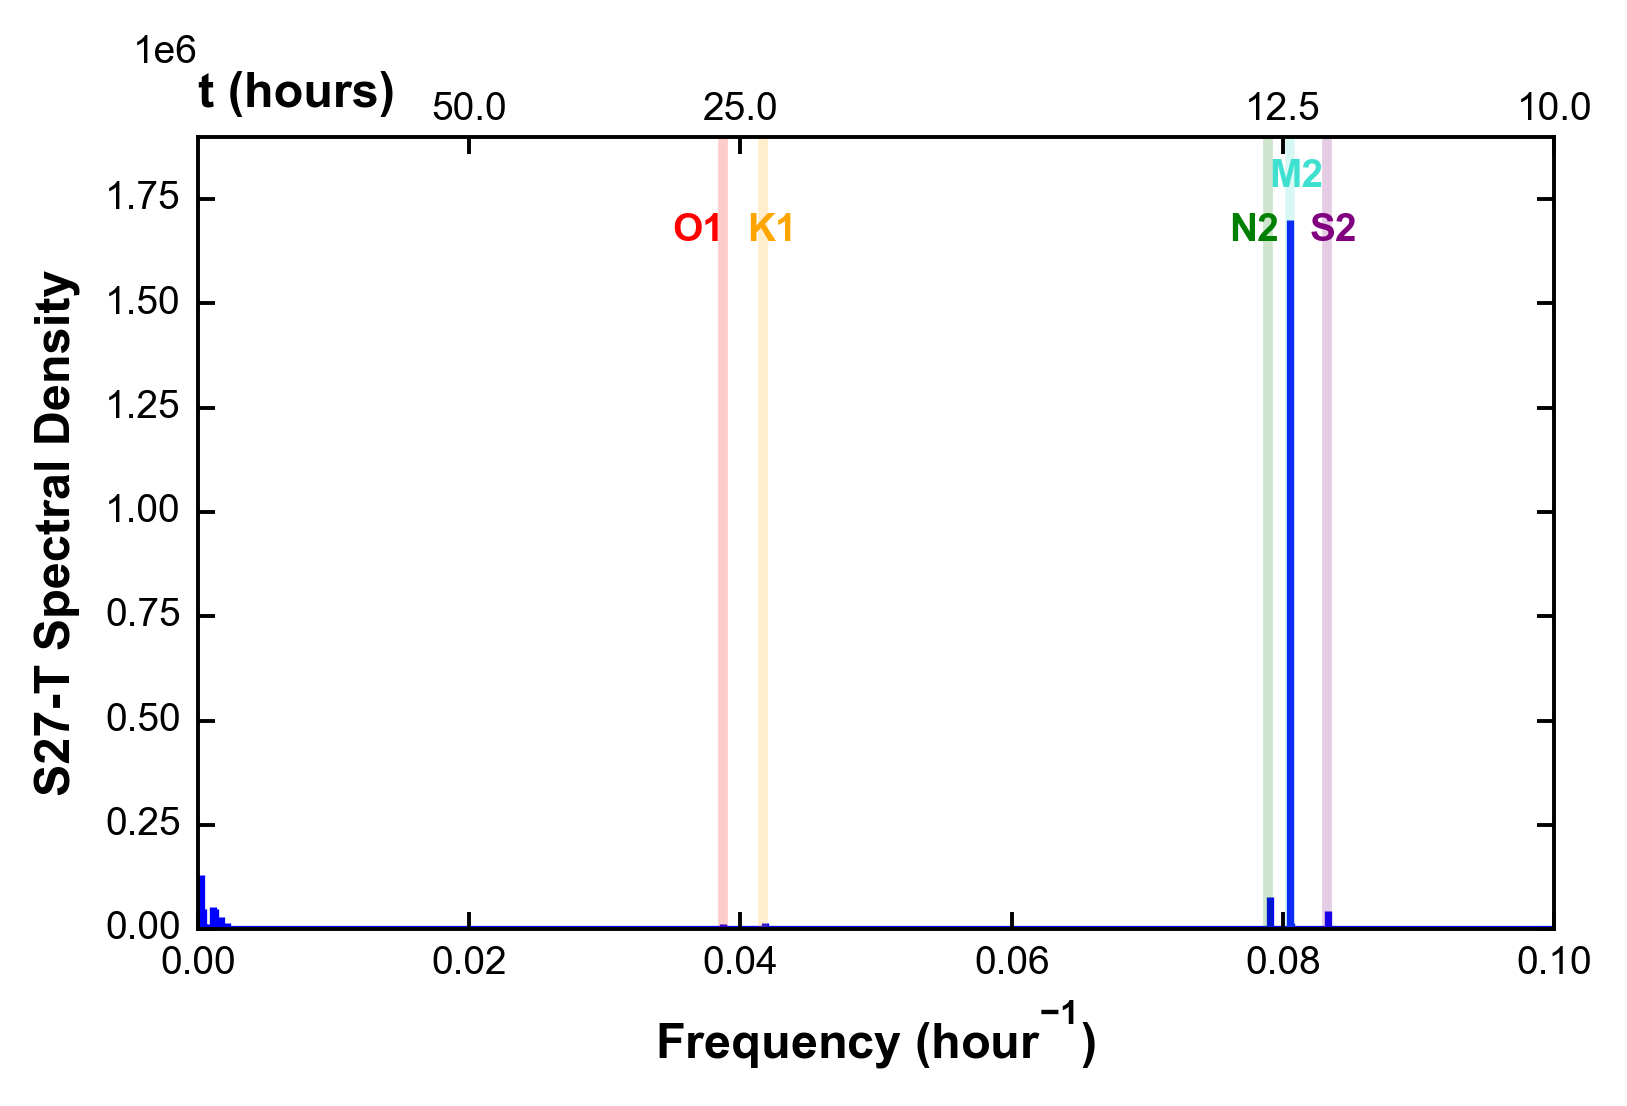

In [18]:
df['s27t'] = df['s27t'].interpolate(method='linear')
nan_true = df['s27t'].isnull().values.any() #check if there are nan values
print('Are there NaN values? ',nan_true)
quantity_nan = df['s27t'].isnull().sum() # how many nan values
print('There are: ', quantity_nan, 'NaN')

#Find linear trend
short = df.iloc[0:1242,:]
tide = df['s27t']*0.3048
coeff_obs = np.polyfit(df['index'],tide, 1)
print('The linear trend coefficients for observed tide are', coeff_obs[0], 'mm hr-1 and ', coeff_obs[1], 'mm')
print('The linear trend coefficients for observed tide are', coeff_obs[0]*24*365.25, 'mm yr-1 and ', coeff_obs[1], 'mm')
trend_obs = np.polyval(coeff_obs, df['index'])
SL_detrend_obs = np.subtract(tide, trend_obs)

# We now compute the Fourier transform and the spectral density of the signal. 
# The first step is to compute the FFT of the signal using the fft() function:
tide_fft_obs = np.fft.fft(SL_detrend_obs)

# Once the FFT has been obtained, square  
# its absolute value in order to get the power spectral density (PSD):
tide_psd_obs = np.abs(tide_fft_obs) ** 2

# The next step is to get the frequencies corresponding to the values of the PSD. 
# The fftfreq() utility function does just that. 
# It takes the length of the PSD vector as input as well as the frequency unit. 
# Here, we choose an annual unit: a frequency of 1 corresponds to 1 year (365.25 days),(1 day = 24 hours). 
# We divide 1/(365.25*24) because the original unit is in hours:
fftfreqs_obs = np.fft.fftfreq(len(tide))

# The fftfreq() function returns positive and negative frequencies. 
# We are only interested in positive frequencies here, as we have a real signal:
i = fftfreqs_obs > 0
print('Fourier Transform')
print(tide_fft_obs[706])
f2_obs = np.log10(tide_psd_obs[i])
print('power spectral density')
print(tide_psd_obs[706])
print('log10 power spectral density')
print(f2_obs[706])
print('frequencies (hour^-1)')
f1_obs=fftfreqs_obs[i]
print(f1_obs[705:710])
print('fft amplitude (m)')
amp_obs = 2.*np.abs(tide_fft_obs[i])/len(tide_fft_obs)
print(amp_obs[706]) 
#print(2.*np.abs(tide_fft[i])/len(tide_fft))
print('periods (hours)')
print(1/f1_obs[706])
print(len(tide_fft_obs[i]))
print(len(fftfreqs_obs[i]))

tide_fft_selected_obs = tide_fft_obs.copy()
tide_fft_selected_obs[np.abs(fftfreqs_obs) >0.0806] = 0
tide_fft_selected_obs[np.abs(fftfreqs_obs) <0.0804] = 0
t_slow_obs = np.real(sp.fftpack.ifft(tide_fft_selected_obs))
np.savetxt('test.csv',t_slow_obs)

vspan_start1 = fftfreqs_obs[fftfreqs_obs==0.08]
vspan_end1 = 1.92
vspan_start2 = 0.099
vspan_end2 = 0.101
xlim_start = 0.000
xlim_end = 0.10

n2 = 0.076
m2 = 0.079
s2 =0.082
k1 = 0.0405
o1 = 0.035
tt1 = 1780000
tt = 1650000

i = fftfreqs_obs > 0
new_tick_locations = np.array([0.02, 0.04,0.08,0.1])
def tick_function(X):
    V = 1/X
    return ["%.1f" % z for z in V]

plt.figure(figsize=(5,3))

ax = host_subplot(111, axes_class=AA.Axes)
ax.set_xlim([0,xlim_end])
ax.set_ylim([0,1900000])
ax.set_xlabel('Frequency ($\mathregular{hour^{-1}}$)')
ax.set_ylabel('S27-T Spectral Density')
ax.set_title('t (hours)', loc='left')
ax2 = ax.twin() # ax2 is responsible for "top" axis and "right" axis
ax2.axis["top"].major_ticklabels.set_visible(True)
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tick_function(new_tick_locations))
plt.stem(fftfreqs_obs[i], tide_psd_obs[i], 'b', \
         markerfmt=" ", basefmt="-b")
ax.axvline(x = fftfreqs_obs[366],linewidth=2,linestyle= '-', color= 'orange', alpha=0.2)
ax.axvline(x = fftfreqs_obs[693],linewidth=2,linestyle= '-', color= 'green', alpha=0.2)
ax.axvline(x = fftfreqs_obs[707],linewidth=2,linestyle= '-', color= 'turquoise', alpha=0.2)
ax.axvline(x = fftfreqs_obs[731],linewidth=2,linestyle= '-', color= 'purple', alpha=0.2)
ax.axvline(x = fftfreqs_obs[340],linewidth=2,linestyle= '-', color= 'red', alpha=0.2)
ax.text(n2, tt, 'N2',color='green', size=8, weight='heavy')
ax.text(m2, tt1, 'M2',color='turquoise', size=8, weight='heavy')
ax.text(s2,tt, 'S2',color='purple', size=8, weight='heavy')
ax.text(k1, tt, 'K1',color='orange', size=8, weight='heavy')
ax.text(o1, tt, 'O1',color='red', size=8, weight='heavy')